**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_1_)    
    - [Chargement données](#toc1_1_2_)    
    - [Complétude des datasets](#toc1_1_3_)    
      - [sources (EdStatsCountry-Series)](#toc1_1_3_1_)    
      - [country_stats (EdStatsCountry)](#toc1_1_3_2_)    
      - [indicateurs (EdStatsData)](#toc1_1_3_3_)    
      - [notes_indicateurs (EdStatsFootNote)](#toc1_1_3_4_)    
      - [series (EdStatsSeries)](#toc1_1_3_5_)    
    - [Selection des données pertinentes](#toc1_1_4_)    
    - [Nettoyage des données](#toc1_1_5_)    
      - [Imputation des indicateurs avec des données manquantes sur certaines années](#toc1_1_5_1_)    
      - [Création du dataframe qui servira au calcul des scores](#toc1_1_5_2_)    
      - [Filtre des pays avec une population suffisante pour un développement commercial](#toc1_1_5_3_)    
      - [Filtre sur les lignes représentant un agglomérat de pays ex:World](#toc1_1_5_4_)    
      - [Calcul d'indicateurs par % de population pour les indicateurs absolus](#toc1_1_5_5_)    
      - [Recherche des valeurs abhérentes](#toc1_1_5_6_)    
      - [Imputation des données manquantes avec les moyennes sur les pays de la même région et du même "Income Group"](#toc1_1_5_7_)    
    - [Visualisation des données](#toc1_1_6_)    
    - [Calcul d'un score global par pays](#toc1_1_7_)    
      - [Version 1 : moyenne non pondérée des indicateurs normalisés](#toc1_1_7_1_)    
        - [Visualisations des scores](#toc1_1_7_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

### <a id='toc1_1_2_'></a>[Chargement données](#toc0_)

In [3]:
sources=pd.read_csv('../Projet2/data/EdStatsCountry-Series.csv')
sources['Unnamed: 3'].unique()
sources.head()

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.,NaN
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population...,NaN


In [4]:
country_stats=pd.read_csv('../Projet2/data/EdStatsCountry.csv')
country_stats.head()

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN


In [5]:
indicateurs=pd.read_csv('../Projet2/data/EdStatsData.csv')
indicateurs.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
notes_indicateurs=pd.read_csv('../Projet2/data/EdStatsFootNote.csv')
notes_indicateurs.head()

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.,NaN
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.,NaN


In [7]:
series=pd.read_csv('../Projet2/data/EdStatsSeries.csv')
series.head()

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAR.NOED.15UP.ZS,Attainment,Barro-Lee: Percentage of population age 15+ wi...,Percentage of population age 15+ with no educa...,Percentage of population age 15+ with no educa...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BAR.NOED.2024.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 20-24 with...,Percentage of female population age 20-24 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a id='toc1_1_3_'></a>[Complétude des datasets](#toc0_)

#### <a id='toc1_1_3_1_'></a>[sources (EdStatsCountry-Series)](#toc0_)

In [8]:
print('Dataset : sources','\n', 'Nombre de lignes : ',sources.shape[0],'\n','Nombre de colonnes : ', sources.shape[1])

Dataset : sources 
 Nombre de lignes :  613 
 Nombre de colonnes :  4


In [9]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB


In [10]:
print('Nombre de lignes dupliquées = ', sources.duplicated(subset=['CountryCode','SeriesCode']).sum())

Nombre de lignes dupliquées =  0


Le dataset "sources" issu de EdStatsCountry-Series est globalement de bonne qualité. Seule la colonne 'Unnamed: 3" contient des Nans et il n'y a pas de lignes dupliquées.

In [11]:
#Suppression des colonnes vides
sources.dropna(axis=1,how='all',inplace=True)

#### <a id='toc1_1_3_2_'></a>[country_stats (EdStatsCountry)](#toc0_)

In [12]:
print('Dataset : country_stats','\n','Nombre de lignes : ',country_stats.shape[0],'\n','Nombre de colonnes : ', country_stats.shape[1])

Dataset : country_stats 
 Nombre de lignes :  241 
 Nombre de colonnes :  32


In [13]:
country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

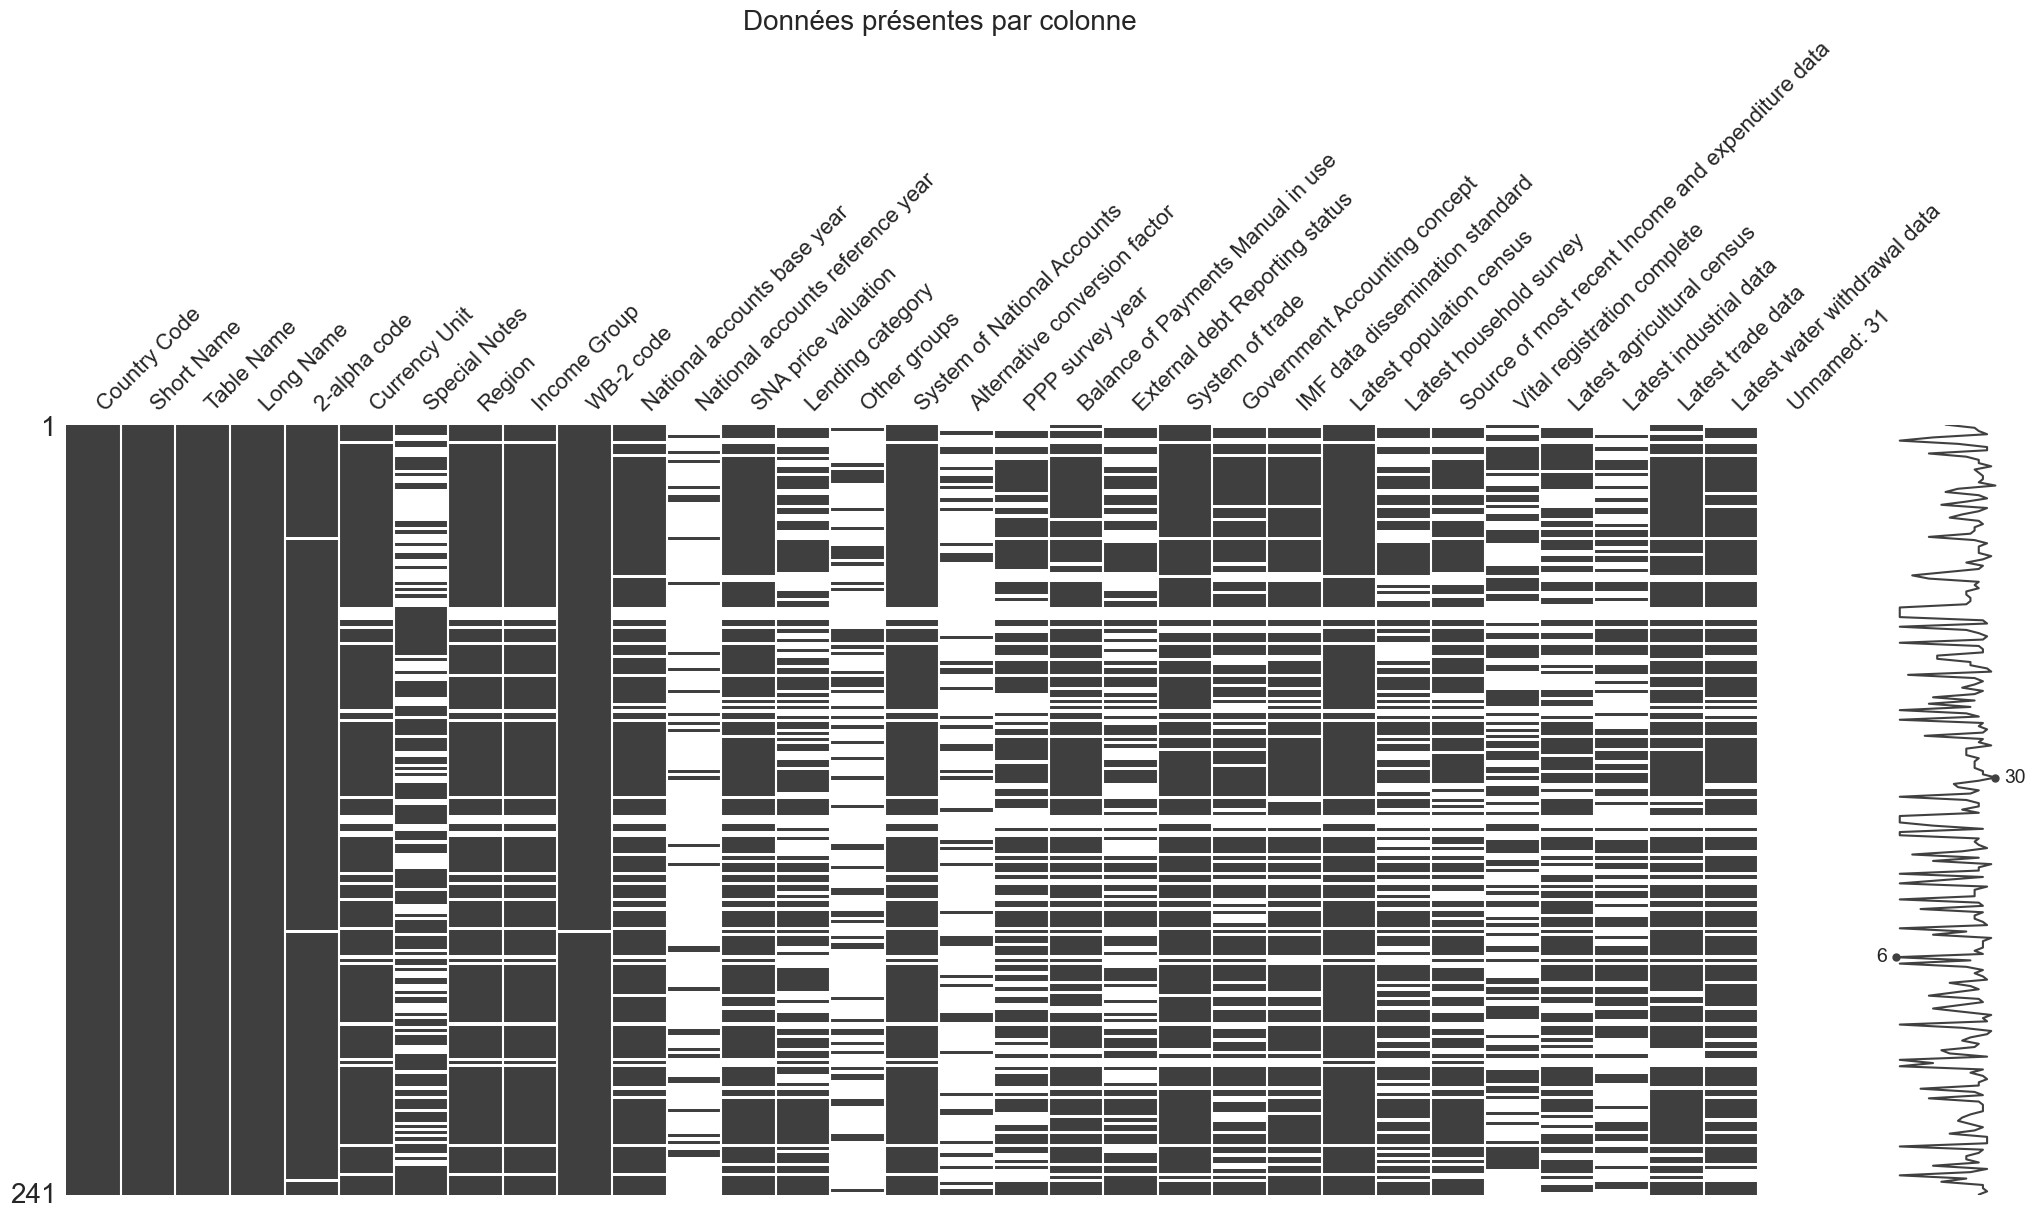

In [14]:
msno.matrix(country_stats)
plt.title('Données présentes par colonne',fontsize = 20)
plt.show()

In [15]:
#Colonnes vides :
country_stats.loc[:,country_stats.isna().all()].columns

Index(['Unnamed: 31'], dtype='object')

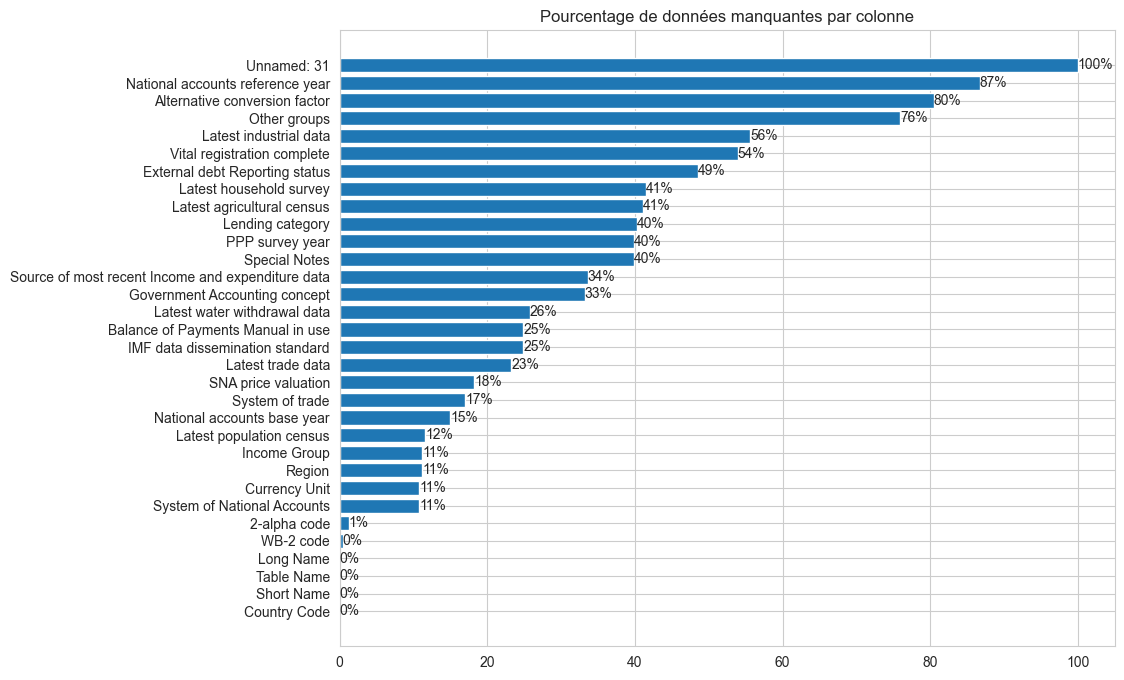

In [16]:
#Données manquantes
pourcentage_manquantes_country=100*country_stats.isna().sum().sort_values()/country_stats.shape[0]

plt.figure(figsize=(10,8))
fig=plt.barh(pourcentage_manquantes_country.index,pourcentage_manquantes_country)
plt.title('Pourcentage de données manquantes par colonne')
plt.bar_label(fig,fmt='{0:.0f}%')
plt.show()


In [17]:
print('Nombre de lignes dupliquées = ', country_stats.duplicated(subset=['Country Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Country Code, Short Name, Table Name et Long Name sont completes. 
Les autres colonnes présentent beaucoup de données manquantes. Il n'y a pas de lignes dupliquées.

In [18]:
country_stats.describe()

,National accounts reference year,Latest industrial data,Latest trade data,Unnamed: 31
count,32.00000,107.000000,185.000000,0.0
mean,2001.53125,2008.102804,2010.994595,NaN
std,5.24856,2.616834,2.569675,NaN
min,1987.00000,2000.000000,1995.000000,NaN
25%,1996.75000,2007.500000,2011.000000,NaN
50%,2002.00000,2009.000000,2012.000000,NaN
75%,2005.00000,2010.000000,2012.000000,NaN
max,2012.00000,2010.000000,2012.000000,NaN


In [19]:
#Suppression des colonnes vides
country_stats.dropna(axis=1,how='all',inplace=True)

#### <a id='toc1_1_3_3_'></a>[indicateurs (EdStatsData)](#toc0_)

In [20]:
print('Dataset : indicateurs','\n','Nombre de lignes : ',indicateurs.shape[0],'\n','Nombre de colonnes : ', indicateurs.shape[1])

Dataset : indicateurs 
 Nombre de lignes :  886930 
 Nombre de colonnes :  70


In [21]:
indicateurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

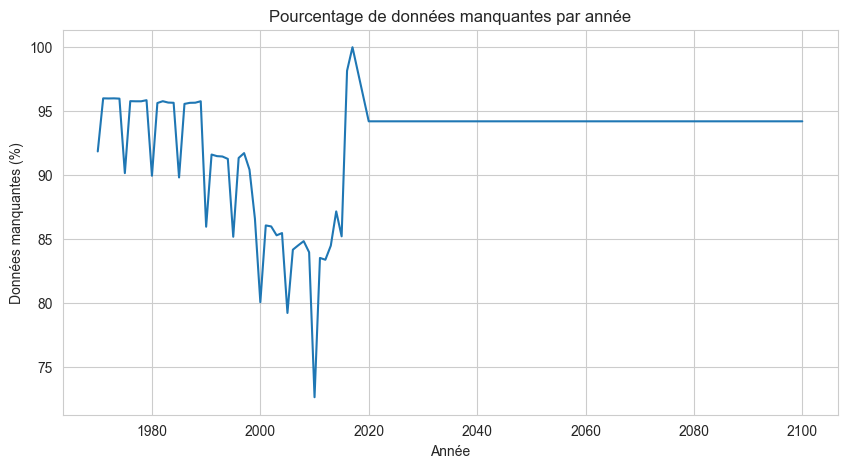

In [22]:
#Données manquantes :

filtre=[col.isdigit() for col in indicateurs.columns]
pourcentage_manquantes_ind=100*indicateurs.loc[:,filtre].isna().sum()/indicateurs.shape[0]
pourcentage_manquantes_ind.index=pd.to_datetime(pourcentage_manquantes_ind.index)

plt.plot(pourcentage_manquantes_ind.index,pourcentage_manquantes_ind)
plt.title('Pourcentage de données manquantes par année')
plt.xlabel('Année')
plt.ylabel('Données manquantes (%)')
plt.show()


In [23]:
print('Nombre de lignes dupliquées = ', indicateurs.duplicated(subset=['Country Code','Indicator Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Country Name, Country Code, Indicator Name  et Indicator Code sont completes. Les données par année présentent beaucoup de données manquantes (>70%). Il n'y a pas de lignes dupliquées.

In [24]:
indicateurs.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,0.0
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,...,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02,NaN
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,...,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04,NaN
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,...,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01,NaN
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,...,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,NaN
50%,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01,NaN
75%,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,...,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00,NaN
max,1.903929e+13,1.986457e+13,2.100916e+13,2.238367e+13,2.282991e+13,2.300634e+13,2.424128e+13,2.521383e+13,2.622101e+13,2.730873e+13,...,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06,NaN


In [25]:
#Suppression des colonnes vides
indicateurs.dropna(axis=1,how='all',inplace=True)

#### <a id='toc1_1_3_4_'></a>[notes_indicateurs (EdStatsFootNote)](#toc0_)

In [26]:
print('Dataset : notes_indicateurs','\n','Nombre de lignes : ',notes_indicateurs.shape[0],'\n','Nombre de colonnes : ', notes_indicateurs.shape[1])

Dataset : notes_indicateurs 
 Nombre de lignes :  643638 
 Nombre de colonnes :  5


In [27]:
notes_indicateurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB


In [28]:
print('Nombre de lignes dupliquées = ', notes_indicateurs.duplicated(subset=['CountryCode','SeriesCode','Year']).sum())

Nombre de lignes dupliquées =  0


Le dataset "notes_indicateurs" est globalement de bonne qualité. Seule la colonne 'Unnamed: 4" contient des Nans et il n'y a pas de lignes dupliquées.

In [29]:
#Suppression des colonnes vides
notes_indicateurs.dropna(axis=1,how='all',inplace=True)

#### <a id='toc1_1_3_5_'></a>[series (EdStatsSeries)](#toc0_)

In [30]:
print('Dataset : series','\n','Nombre de lignes : ',series.shape[0],'\n','Nombre de colonnes : ', series.shape[1])

Dataset : series 
 Nombre de lignes :  3665 
 Nombre de colonnes :  21


In [31]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Series Code                          3665 non-null   object 
 1   Topic                                3665 non-null   object 
 2   Indicator Name                       3665 non-null   object 
 3   Short definition                     2156 non-null   object 
 4   Long definition                      3665 non-null   object 
 5   Unit of measure                      0 non-null      float64
 6   Periodicity                          99 non-null     object 
 7   Base Period                          314 non-null    object 
 8   Other notes                          552 non-null    object 
 9   Aggregation method                   47 non-null     object 
 10  Limitations and exceptions           14 non-null     object 
 11  Notes from original source    

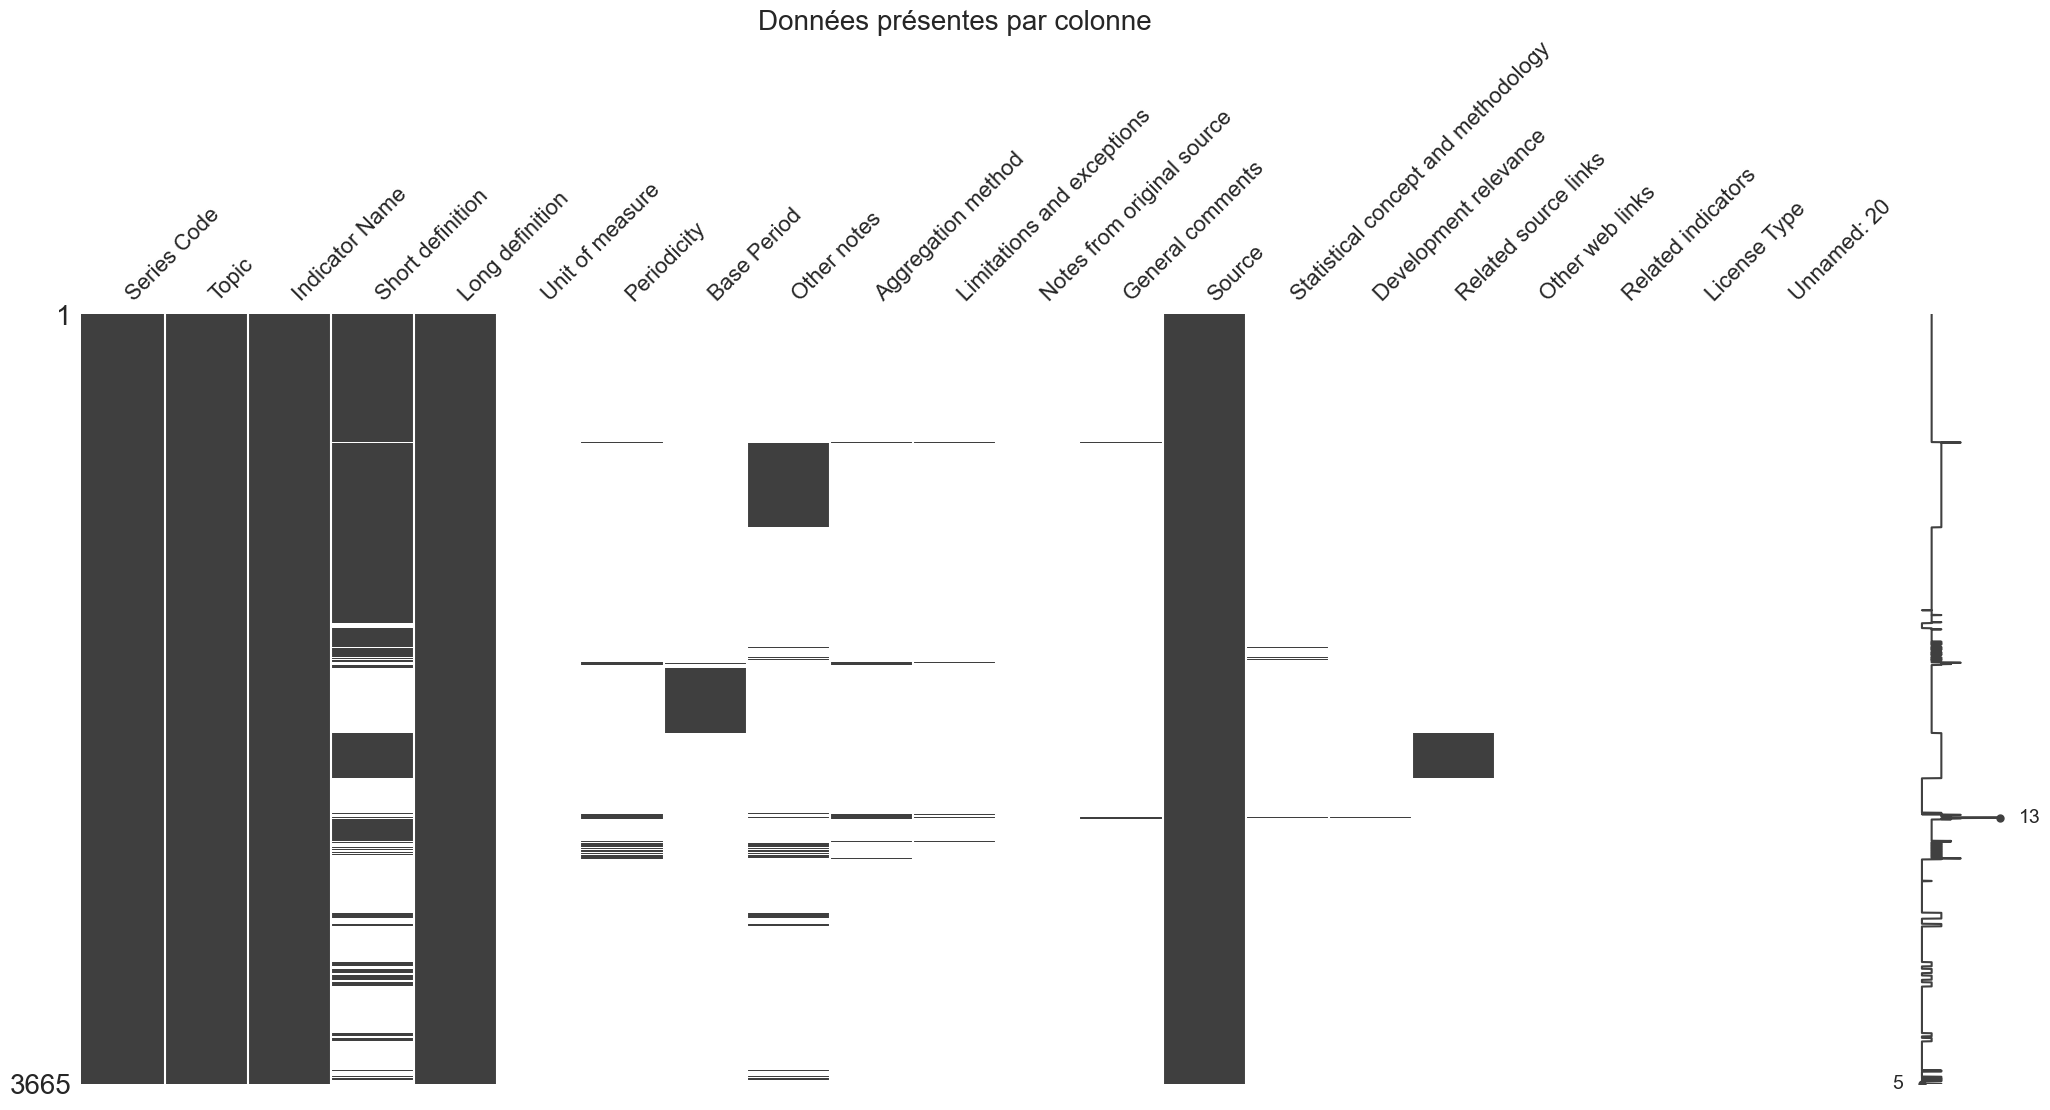

In [32]:
msno.matrix(series)
plt.title('Données présentes par colonne',fontsize = 20)
plt.show()

In [33]:
#Colonnes vides :
series.loc[:,series.isna().all()].columns

Index(['Unit of measure', 'Notes from original source', 'Other web links',
       'Related indicators', 'License Type', 'Unnamed: 20'],
      dtype='object')

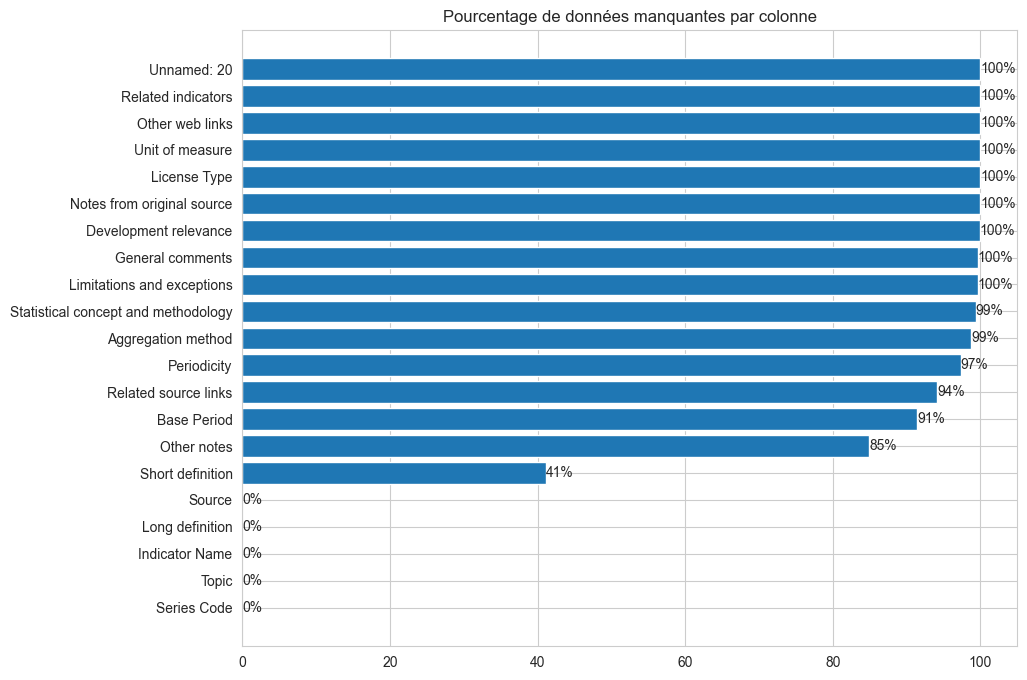

In [34]:
#Données manquantes
pourcentage_manquantes_series=100*series.isna().sum().sort_values()/series.shape[0]

plt.figure(figsize=(10,8))
fig=plt.barh(pourcentage_manquantes_series.index,pourcentage_manquantes_series)
plt.title('Pourcentage de données manquantes par colonne')
plt.bar_label(fig,fmt='{0:.0f}%')
plt.show()

In [35]:
print('Nombre de lignes dupliquées = ', series.duplicated(subset=['Series Code']).sum())

Nombre de lignes dupliquées =  0


Parmi les colonnes disponibles : Series Code, Topic, Indicator Name, Long definition et Source sont completes. Short definition est partiellement renseignée (41% de données manquantes). Les autres colonnes présentent un taux élévé de Nans (>=85%) ou sont vides.

In [36]:
#Suppression des colonnes vides
series.dropna(axis=1,how='all',inplace=True)

### <a id='toc1_1_4_'></a>[Selection des données pertinentes](#toc0_)

In [37]:
indicateurs['Indicator Name'].unique().tolist()

['Adjusted net enrolment rate, lower secondary, both sexes (%)',
 'Adjusted net enrolment rate, lower secondary, female (%)',
 'Adjusted net enrolment rate, lower secondary, gender parity index (GPI)',
 'Adjusted net enrolment rate, lower secondary, male (%)',
 'Adjusted net enrolment rate, primary, both sexes (%)',
 'Adjusted net enrolment rate, primary, female (%)',
 'Adjusted net enrolment rate, primary, gender parity index (GPI)',
 'Adjusted net enrolment rate, primary, male (%)',
 'Adjusted net enrolment rate, upper secondary, both sexes (%)',
 'Adjusted net enrolment rate, upper secondary, female (%)',
 'Adjusted net enrolment rate, upper secondary, gender parity index (GPI)',
 'Adjusted net enrolment rate, upper secondary, male (%)',
 'Adjusted net intake rate to Grade 1 of primary education, both sexes (%)',
 'Adjusted net intake rate to Grade 1 of primary education, female (%)',
 'Adjusted net intake rate to Grade 1 of primary education, gender parity index (GPI)',
 'Adjusted 

In [38]:
#Labels intéressants :

filtre_indicateurs_souhaites=indicateurs['Indicator Name'].isin([
'Adjusted net enrolment rate, upper secondary, both sexes (%)',
'Adult literacy rate, population 15+ years, both sexes (%)',
'Barro-Lee: Average years of secondary schooling, age 25+, total',
'Barro-Lee: Average years of tertiary schooling, age 75+, total',
'Barro-Lee: Percentage of population age 15-19 with secondary schooling. Total (Incomplete and Completed Secondary)',
'Barro-Lee: Percentage of population age 25-29 with secondary schooling. Completed Secondary',
'Barro-Lee: Percentage of population age 25-29 with tertiary schooling. Total (Incomplete and Completed Tertiary)',
'Barro-Lee: Percentage of population age 75+ with tertiary schooling. Total (Incomplete and Completed Tertiary)',
'DHS: Average years of schooling by age group. Age 15-19',
'DHS: Secondary completion rate',
'Duration of compulsory education (years)',
'Enrolment in secondary education, both sexes (number)',
'Enrolment in tertiary education, all programmes, both sexes (number)',
'Internet users (per 100 people)',
'MICS: Secondary completion rate',
'Personal computers (per 100 people)',
'PISA: Mean performance on the mathematics scale',
'PISA: Mean performance on the reading scale',
'PISA: Mean performance on the science scale',
'Population, total',
'Pupil-teacher ratio in tertiary education (headcount basis)',
'Pupil-teacher ratio in upper secondary education (headcount basis)',
'SACMEQ: Mean performance on the mathematics scale',
'SACMEQ: Mean performance on the reading scale, total',
'UIS: Mean years of schooling of the population age 25+. Total',
"UIS: Percentage of population age 25+ with at least a completed bachelor's or equivalent degree (ISCED 6 or higher). Total",
'UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total'])


In [39]:
#% de données disponibles pour ces indicateurs :

nbr_colonnes=len(indicateurs[filtre_indicateurs_souhaites].groupby('Indicator Name').count().columns)
nbr_pays=len(indicateurs['Country Name'].unique())

(indicateurs[filtre_indicateurs_souhaites].groupby('Indicator Name').count().sum(axis=1)/(nbr_pays*nbr_colonnes)*100
 ).round(1).sort_values(ascending=False)

Indicator Name
Population, total                                                                                                             72.2
Enrolment in secondary education, both sexes (number)                                                                         49.4
Enrolment in tertiary education, all programmes, both sexes (number)                                                          44.6
Internet users (per 100 people)                                                                                               37.5
Pupil-teacher ratio in tertiary education (headcount basis)                                                                   26.5
Duration of compulsory education (years)                                                                                      25.3
Personal computers (per 100 people)                                                                                           21.4
Pupil-teacher ratio in upper secondary education (headcount basis)  

In [40]:
liste_retenus=[
    'Population, total',
    'Enrolment in secondary education, both sexes (number)' ,
    'Enrolment in tertiary education, all programmes, both sexes (number)' ,
    'Internet users (per 100 people)',
    'Pupil-teacher ratio in tertiary education (headcount basis)',
    'Duration of compulsory education (years)' ,
    'Personal computers (per 100 people)',
    'Pupil-teacher ratio in upper secondary education (headcount basis)']
filtre_retenus=indicateurs['Indicator Name'].isin(liste_retenus)
indicateurs_retenus=indicateurs[filtre_retenus]

#Colonnes non vides pour les indicateurs retenus
indicateurs_retenus.dropna(axis=1,how='all').columns



Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016'],
      dtype='object')

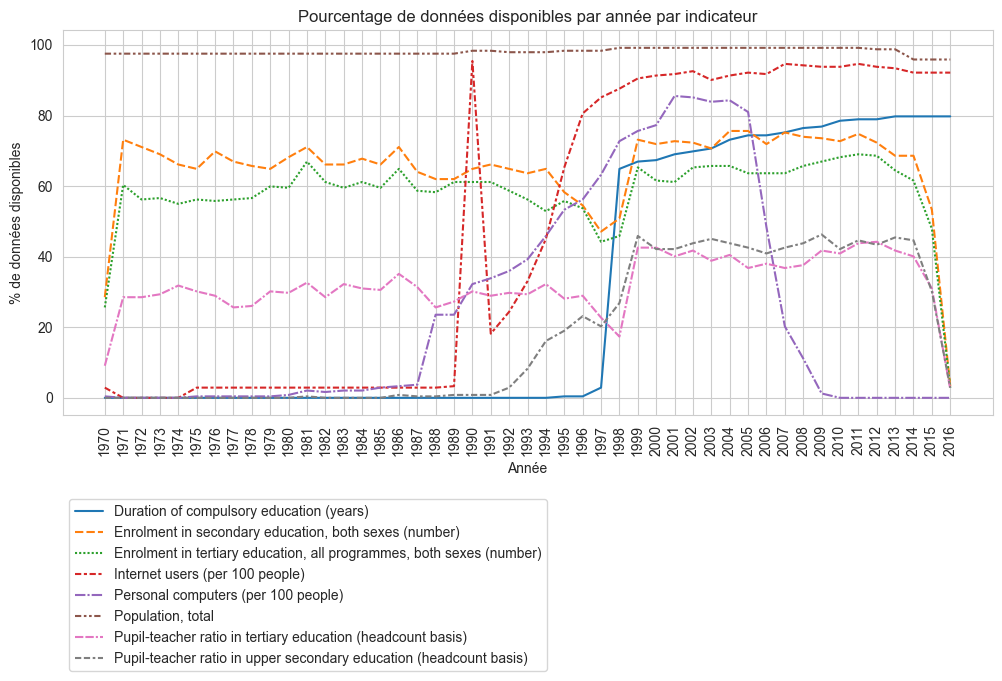

In [41]:
#Données disponibles :

temp=indicateurs_retenus.groupby('Indicator Name').count()

plt.figure(figsize=(12,5))
sns.lineplot(temp.loc[:,'1970':'2016'].T*100/nbr_pays) #calcul des pourcentages pour les années avec des données
plt.title('Pourcentage de données disponibles par année par indicateur')
plt.xlabel('Année')
plt.ylabel("% de données disponibles")
plt.legend(loc='upper left',bbox_to_anchor=(0,-0.2))
plt.xticks(rotation = 90)
plt.show()

Les années 1999 à 2005 contiennent le plus grand nombre de données.
'Internet users' a des données plus récentes que 'Personal computers', pour lequel le nombre de données disponibles décroit rapidement à partir de 2005.
La dernière année avec un taux acceptable de données est 2014 si on exclue l'indicateur 'Personnal computers'.

In [42]:
#Vérification des information personnal computers/internet users
personnal_computers=indicateurs_retenus.loc[indicateurs_retenus['Indicator Name']=='Personal computers (per 100 people)','2005']
internet=indicateurs_retenus.loc[indicateurs_retenus['Indicator Name']=='Internet users (per 100 people)','2005']
country=indicateurs_retenus['Country Name']

pd.DataFrame({'Country Name' :country,'computers':personnal_computers,'internet users':internet}).groupby('Country Name').mean().corr()


,computers,internet users
computers,1.000000,0.912364
internet users,0.912364,1.000000


Les données "Personnal computers" et "Internet users" sont assez fortement corrélées. Comme les données sur "Personnal computers" s'arrêtent à 2005, cet indicateur ne sera pas pris en compte.

In [43]:
#Mise à jour de la liste des retenus et du dataframe indicateurs retenus
liste_retenus.remove('Personal computers (per 100 people)')
filtre_retenus=indicateurs['Indicator Name'].isin(liste_retenus)
indicateurs_retenus=indicateurs[filtre_retenus]

In [44]:
series_retenus=series[series['Indicator Name'].isin(liste_retenus)].dropna(axis=1,how='all')
series_retenus

,Series Code,Topic,Indicator Name,Long definition,Periodicity,Aggregation method,Limitations and exceptions,General comments,Source
611,IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),Internet users are individuals who have used t...,Annual,Weighted average,Operators have traditionally been the main sou...,Please cite the International Telecommunicatio...,"International Telecommunication Union, World T..."
2216,SE.COM.DURS,Background,Duration of compulsory education (years),Number of years that children are legally obli...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2294,SE.SEC.ENRL,Secondary,"Enrolment in secondary education, both sexes (...",Total number of students enrolled at public an...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2332,SE.TER.ENRL,Tertiary,"Enrolment in tertiary education, all programme...",The total number of students enrolled at publi...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
2590,SP.POP.TOTL,Health: Population: Structure,"Population, total",Total population is based on the de facto defi...,Annual,Sum,Current population estimates for developing co...,Relevance to gender indicator: disaggregating ...,(1) United Nations Population Division. World ...
3282,UIS.PTRHC.3,Teachers,Pupil-teacher ratio in upper secondary educati...,Average number of pupils per teacher at a give...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics
3285,UIS.PTRHC.56,Teachers,Pupil-teacher ratio in tertiary education (hea...,Average number of pupils per teacher at a give...,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics


A part la population et les utilisateurs d'internet, le reste des indicateurs proviennent de la même source (UNESCO Institute for Statistics).

In [45]:
#Codes pour les indicateurs retenus :
dict_retenus=dict(zip(series_retenus['Indicator Name'],series_retenus['Series Code']))
dict_retenus

{'Internet users (per 100 people)': 'IT.NET.USER.P2',
 'Duration of compulsory education (years)': 'SE.COM.DURS',
 'Enrolment in secondary education, both sexes (number)': 'SE.SEC.ENRL',
 'Enrolment in tertiary education, all programmes, both sexes (number)': 'SE.TER.ENRL',
 'Population, total': 'SP.POP.TOTL',
 'Pupil-teacher ratio in upper secondary education (headcount basis)': 'UIS.PTRHC.3',
 'Pupil-teacher ratio in tertiary education (headcount basis)': 'UIS.PTRHC.56'}

In [46]:
#Notes complémentaires par année pour ces indicateurs
notes_retenus=notes_indicateurs.loc[notes_indicateurs['SeriesCode'].isin(series_retenus['Series Code'])]
notes_retenus.head()

,CountryCode,SeriesCode,Year,DESCRIPTION
99,ABW,SE.COM.DURS,YR1999,Country data
100,ABW,SE.COM.DURS,YR2000,Country data
101,ABW,SE.COM.DURS,YR2001,Country data
102,ABW,SE.COM.DURS,YR2002,Country data
103,ABW,SE.COM.DURS,YR2003,Country data


In [47]:
#Filtre sur les années avec le plus de données

#Afin de garder des données comparables tout en essayant de garder un maximum de lignes, la moyenne des valeurs des 
# indicateurs pour les 5 dernières années avec un nombre significatif de données (2009 et 2014) sera prise comme indicateur

colonnes_retenues=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2009','2010','2011','2012','2013','2014']

data_raw=indicateurs_retenus.loc[:,colonnes_retenues]
data_raw.dropna(axis=0,subset=[ '2009','2010','2011','2012','2013','2014','2013','2014'],how='all',inplace=True)
data_raw


,Country Name,Country Code,Indicator Name,Indicator Code,2009,2010,2011,2012,2013,2014
1191,Arab World,ARB,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,2.957251e+07,3.013438e+07,3.129979e+07,3.181115e+07,3.125060e+07,3.097225e+07
1204,Arab World,ARB,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,8.382284e+06,8.715273e+06,8.594488e+06,9.147083e+06,9.688632e+06,9.966484e+06
1375,Arab World,ARB,Internet users (per 100 people),IT.NET.USER.P2,2.297369e+01,2.674725e+01,2.970776e+01,3.401422e+01,3.686860e+01,NaN
2533,Arab World,ARB,"Population, total",SP.POP.TOTL,3.401490e+08,3.477370e+08,3.551370e+08,3.624666e+08,3.697615e+08,NaN
2554,Arab World,ARB,Pupil-teacher ratio in upper secondary educati...,UIS.PTRHC.3,1.211638e+01,1.250909e+01,1.328684e+01,1.301317e+01,1.297931e+01,1.360266e+01
...,...,...,...,...,...,...,...,...,...,...
884456,Zimbabwe,ZWE,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,NaN,NaN,NaN,9.367340e+05,9.574610e+05,NaN
884469,Zimbabwe,ZWE,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,NaN,9.461100e+04,9.328500e+04,9.401200e+04,9.411500e+04,NaN
884640,Zimbabwe,ZWE,Internet users (per 100 people),IT.NET.USER.P2,4.000000e+00,6.400000e+00,8.400000e+00,1.200000e+01,1.550000e+01,1.636474e+01
885798,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,1.381060e+07,1.408632e+07,1.438665e+07,1.471083e+07,1.505451e+07,1.541168e+07


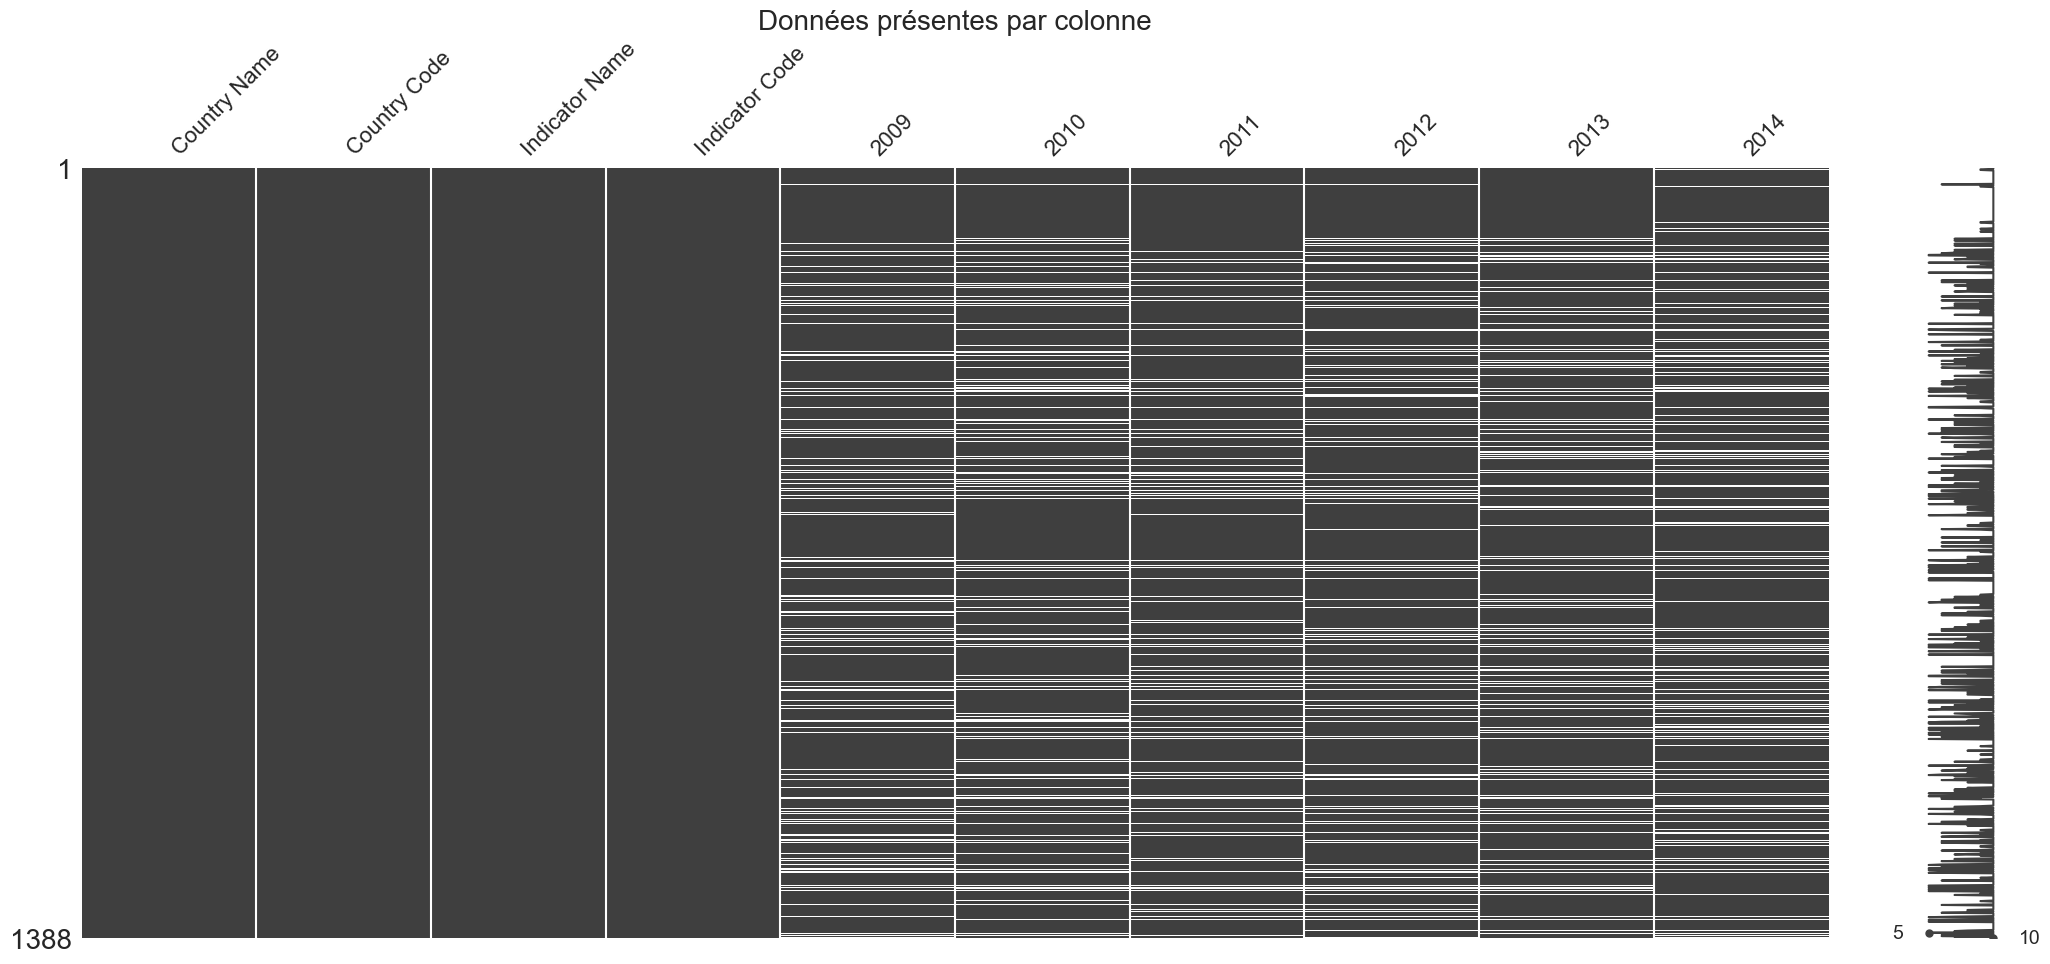

In [48]:
msno.matrix(data_raw)
plt.title('Données présentes par colonne',fontsize = 20)
plt.show()


### <a id='toc1_1_5_'></a>[Nettoyage des données](#toc0_)
#### <a id='toc1_1_5_1_'></a>[Imputation des indicateurs avec des données manquantes sur certaines années](#toc0_)

Avant de calculer la moyenne par indicateur et par pays, les données manquantes par année seront imputées avec la moyenne de cet indicateur pour ce pays sur les années 2009 à 2016.

In [49]:
donnees_a_imputer=data_raw.iloc[:,4:10].T #Selection des colonnes à imputer et transformation pour avoir les individus en colonne pour l'imputer
index=donnees_a_imputer.index
colonnes=donnees_a_imputer.columns
imputer=SimpleImputer(strategy='mean')
data_imp=pd.DataFrame(imputer.fit_transform(donnees_a_imputer),index=index)
data_imp.columns=colonnes
data_imp.T

,2009,2010,2011,2012,2013,2014
1191,2.957251e+07,3.013438e+07,3.129979e+07,3.181115e+07,3.125060e+07,3.097225e+07
1204,8.382284e+06,8.715273e+06,8.594488e+06,9.147083e+06,9.688632e+06,9.966484e+06
1375,2.297369e+01,2.674725e+01,2.970776e+01,3.401422e+01,3.686860e+01,3.006231e+01
2533,3.401490e+08,3.477370e+08,3.551370e+08,3.624666e+08,3.697615e+08,3.550503e+08
2554,1.211638e+01,1.250909e+01,1.328684e+01,1.301317e+01,1.297931e+01,1.360266e+01
...,...,...,...,...,...,...
884456,9.470975e+05,9.470975e+05,9.470975e+05,9.367340e+05,9.574610e+05,9.470975e+05
884469,9.400575e+04,9.461100e+04,9.328500e+04,9.401200e+04,9.411500e+04,9.400575e+04
884640,4.000000e+00,6.400000e+00,8.400000e+00,1.200000e+01,1.550000e+01,1.636474e+01
885798,1.381060e+07,1.408632e+07,1.438665e+07,1.471083e+07,1.505451e+07,1.541168e+07


In [50]:
data_raw=pd.concat([data_raw.iloc[:,:4],data_imp.T],axis=1)
data_raw


,Country Name,Country Code,Indicator Name,Indicator Code,2009,2010,2011,2012,2013,2014
1191,Arab World,ARB,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,2.957251e+07,3.013438e+07,3.129979e+07,3.181115e+07,3.125060e+07,3.097225e+07
1204,Arab World,ARB,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,8.382284e+06,8.715273e+06,8.594488e+06,9.147083e+06,9.688632e+06,9.966484e+06
1375,Arab World,ARB,Internet users (per 100 people),IT.NET.USER.P2,2.297369e+01,2.674725e+01,2.970776e+01,3.401422e+01,3.686860e+01,3.006231e+01
2533,Arab World,ARB,"Population, total",SP.POP.TOTL,3.401490e+08,3.477370e+08,3.551370e+08,3.624666e+08,3.697615e+08,3.550503e+08
2554,Arab World,ARB,Pupil-teacher ratio in upper secondary educati...,UIS.PTRHC.3,1.211638e+01,1.250909e+01,1.328684e+01,1.301317e+01,1.297931e+01,1.360266e+01
...,...,...,...,...,...,...,...,...,...,...
884456,Zimbabwe,ZWE,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,9.470975e+05,9.470975e+05,9.470975e+05,9.367340e+05,9.574610e+05,9.470975e+05
884469,Zimbabwe,ZWE,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,9.400575e+04,9.461100e+04,9.328500e+04,9.401200e+04,9.411500e+04,9.400575e+04
884640,Zimbabwe,ZWE,Internet users (per 100 people),IT.NET.USER.P2,4.000000e+00,6.400000e+00,8.400000e+00,1.200000e+01,1.550000e+01,1.636474e+01
885798,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,1.381060e+07,1.408632e+07,1.438665e+07,1.471083e+07,1.505451e+07,1.541168e+07


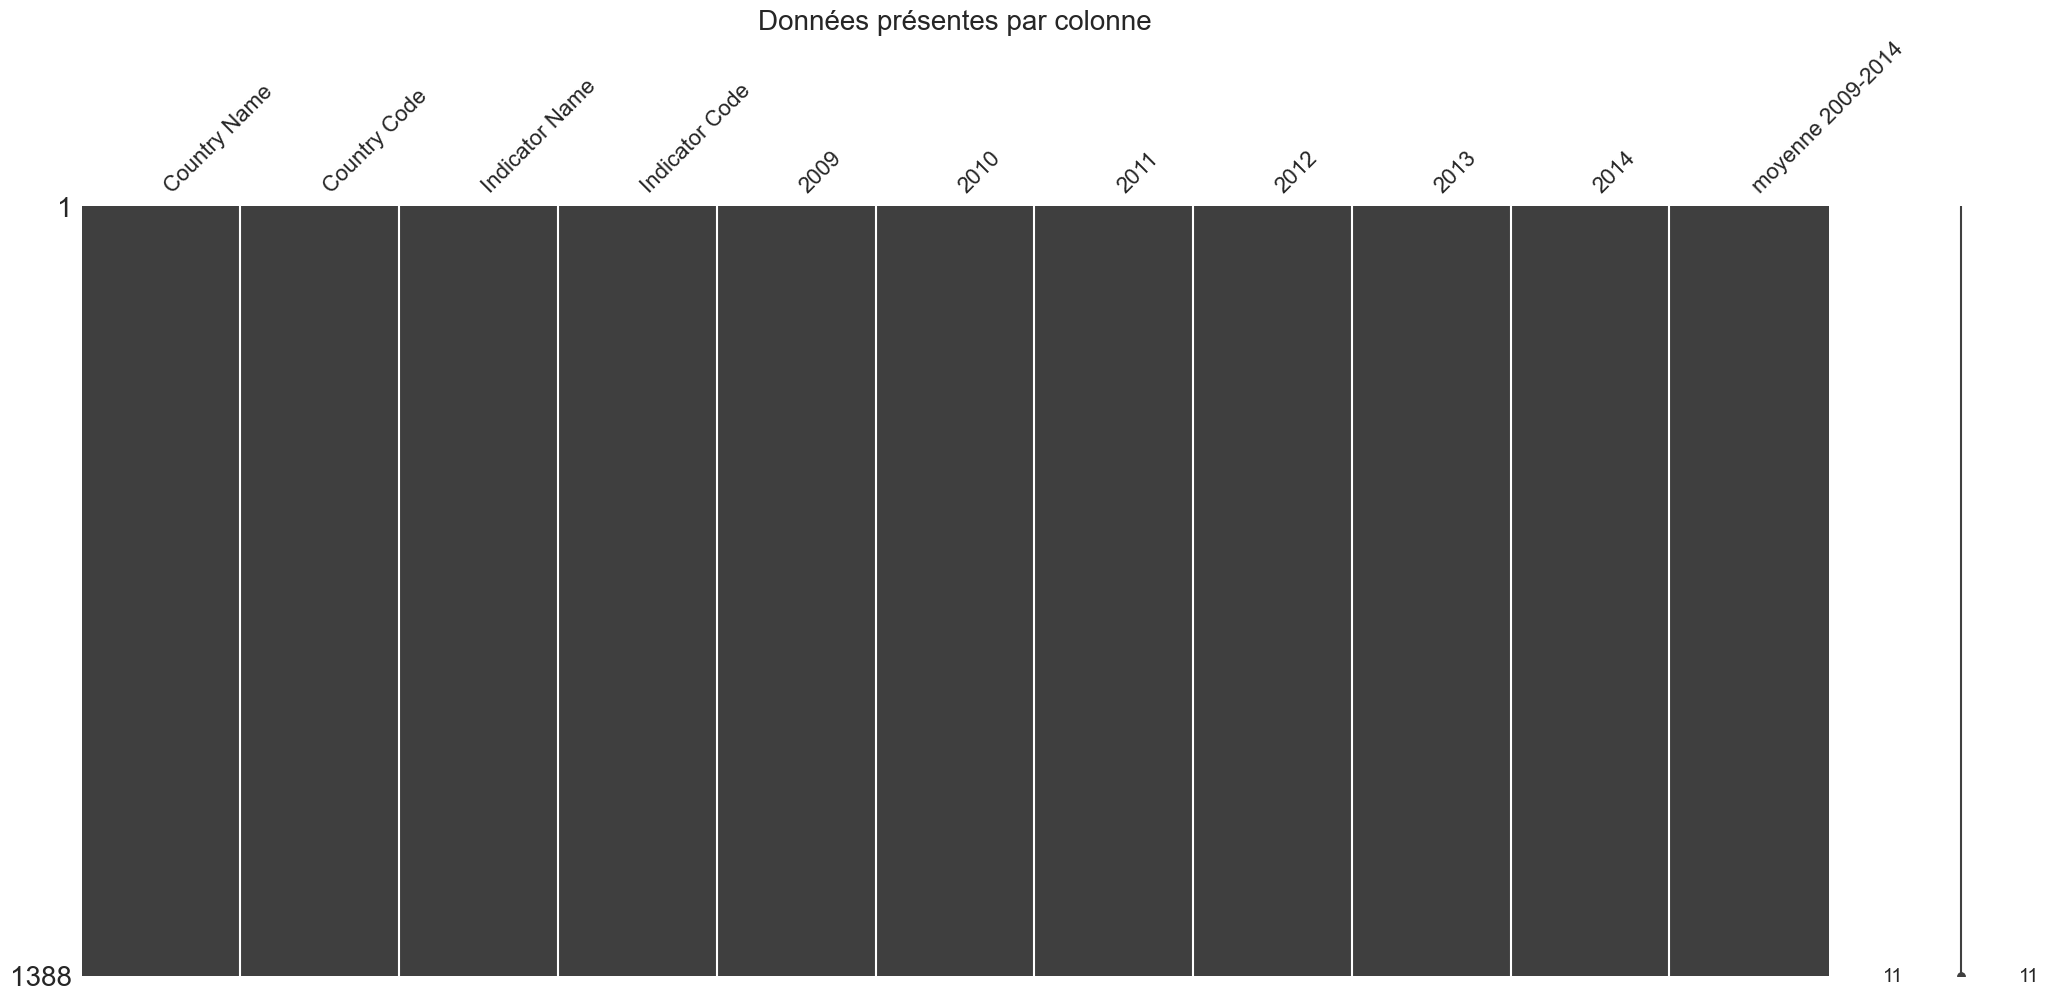

In [51]:
data_raw['moyenne 2009-2014']=data_raw[[str(i) for i in range (2009,2015)]].mean(axis=1)
msno.matrix(data_raw)
plt.title('Données présentes par colonne',fontsize = 20)
plt.show()

In [52]:
def plot_extract(indicator_name): 
    extrait=data_raw.loc[data_raw['Indicator Name']==indicator_name,['Country Name','2009','2010','2011','2012','2013','2014']].sample(10)
    extrait=extrait.melt('Country Name')
    sns.lineplot(data=extrait,x='variable',y='value',hue='Country Name')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.xlabel('Year')
    plt.ylabel(indicator_name)
    plt.title(indicator_name)
    plt.show()

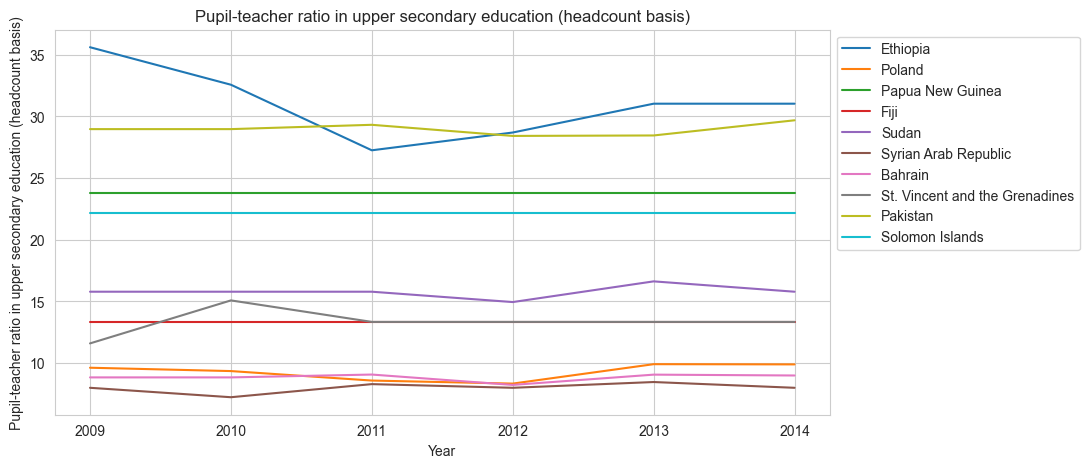

In [53]:
plot_extract('Pupil-teacher ratio in upper secondary education (headcount basis)')

#### <a id='toc1_1_5_2_'></a>[Création du dataframe qui servira au calcul des scores](#toc0_)

In [54]:
data_wrk=data_raw[['Country Name','Country Code','Indicator Name','moyenne 2009-2014']].pivot(index=['Country Name','Country Code'],columns='Indicator Name',values='moyenne 2009-2014')
data_wrk.dropna(axis=0,subset=[col for col in liste_retenus if col!='Population, total'],how='all',inplace=True)
data_wrk.reset_index(inplace=True)
data_wrk

Indicator Name,Country Name,Country Code,Duration of compulsory education (years),"Enrolment in secondary education, both sexes (number)","Enrolment in tertiary education, all programmes, both sexes (number)",Internet users (per 100 people),"Population, total",Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis)
0,Afghanistan,AFG,9.0,2.254391e+06,1.518543e+05,5.150758,3.028379e+07,28.090020,NaN
1,Albania,ALB,8.5,3.490902e+05,1.430048e+05,51.192660,2.905055e+06,20.576073,17.576995
2,Algeria,DZA,10.0,4.588302e+06,1.198471e+06,18.138333,3.723678e+07,27.088920,NaN
3,Andorra,AND,10.0,4.149667e+03,5.090000e+02,86.144071,8.251733e+04,4.345927,NaN
4,Angola,AGO,6.0,8.155160e+05,1.807385e+05,5.633333,2.469203e+07,18.160749,20.505810
...,...,...,...,...,...,...,...,...,...
231,West Bank and Gaza,PSE,10.0,7.085805e+05,2.063028e+05,42.396667,3.991910e+06,27.745385,18.443847
232,World,WLD,NaN,5.577063e+08,1.918756e+08,32.796923,7.056660e+09,NaN,16.698229
233,"Yemen, Rep.",YEM,9.0,1.661876e+06,2.714850e+05,16.201917,2.459442e+07,NaN,24.172729
234,Zambia,ZMB,7.0,NaN,5.621950e+04,12.613033,1.450755e+07,NaN,NaN


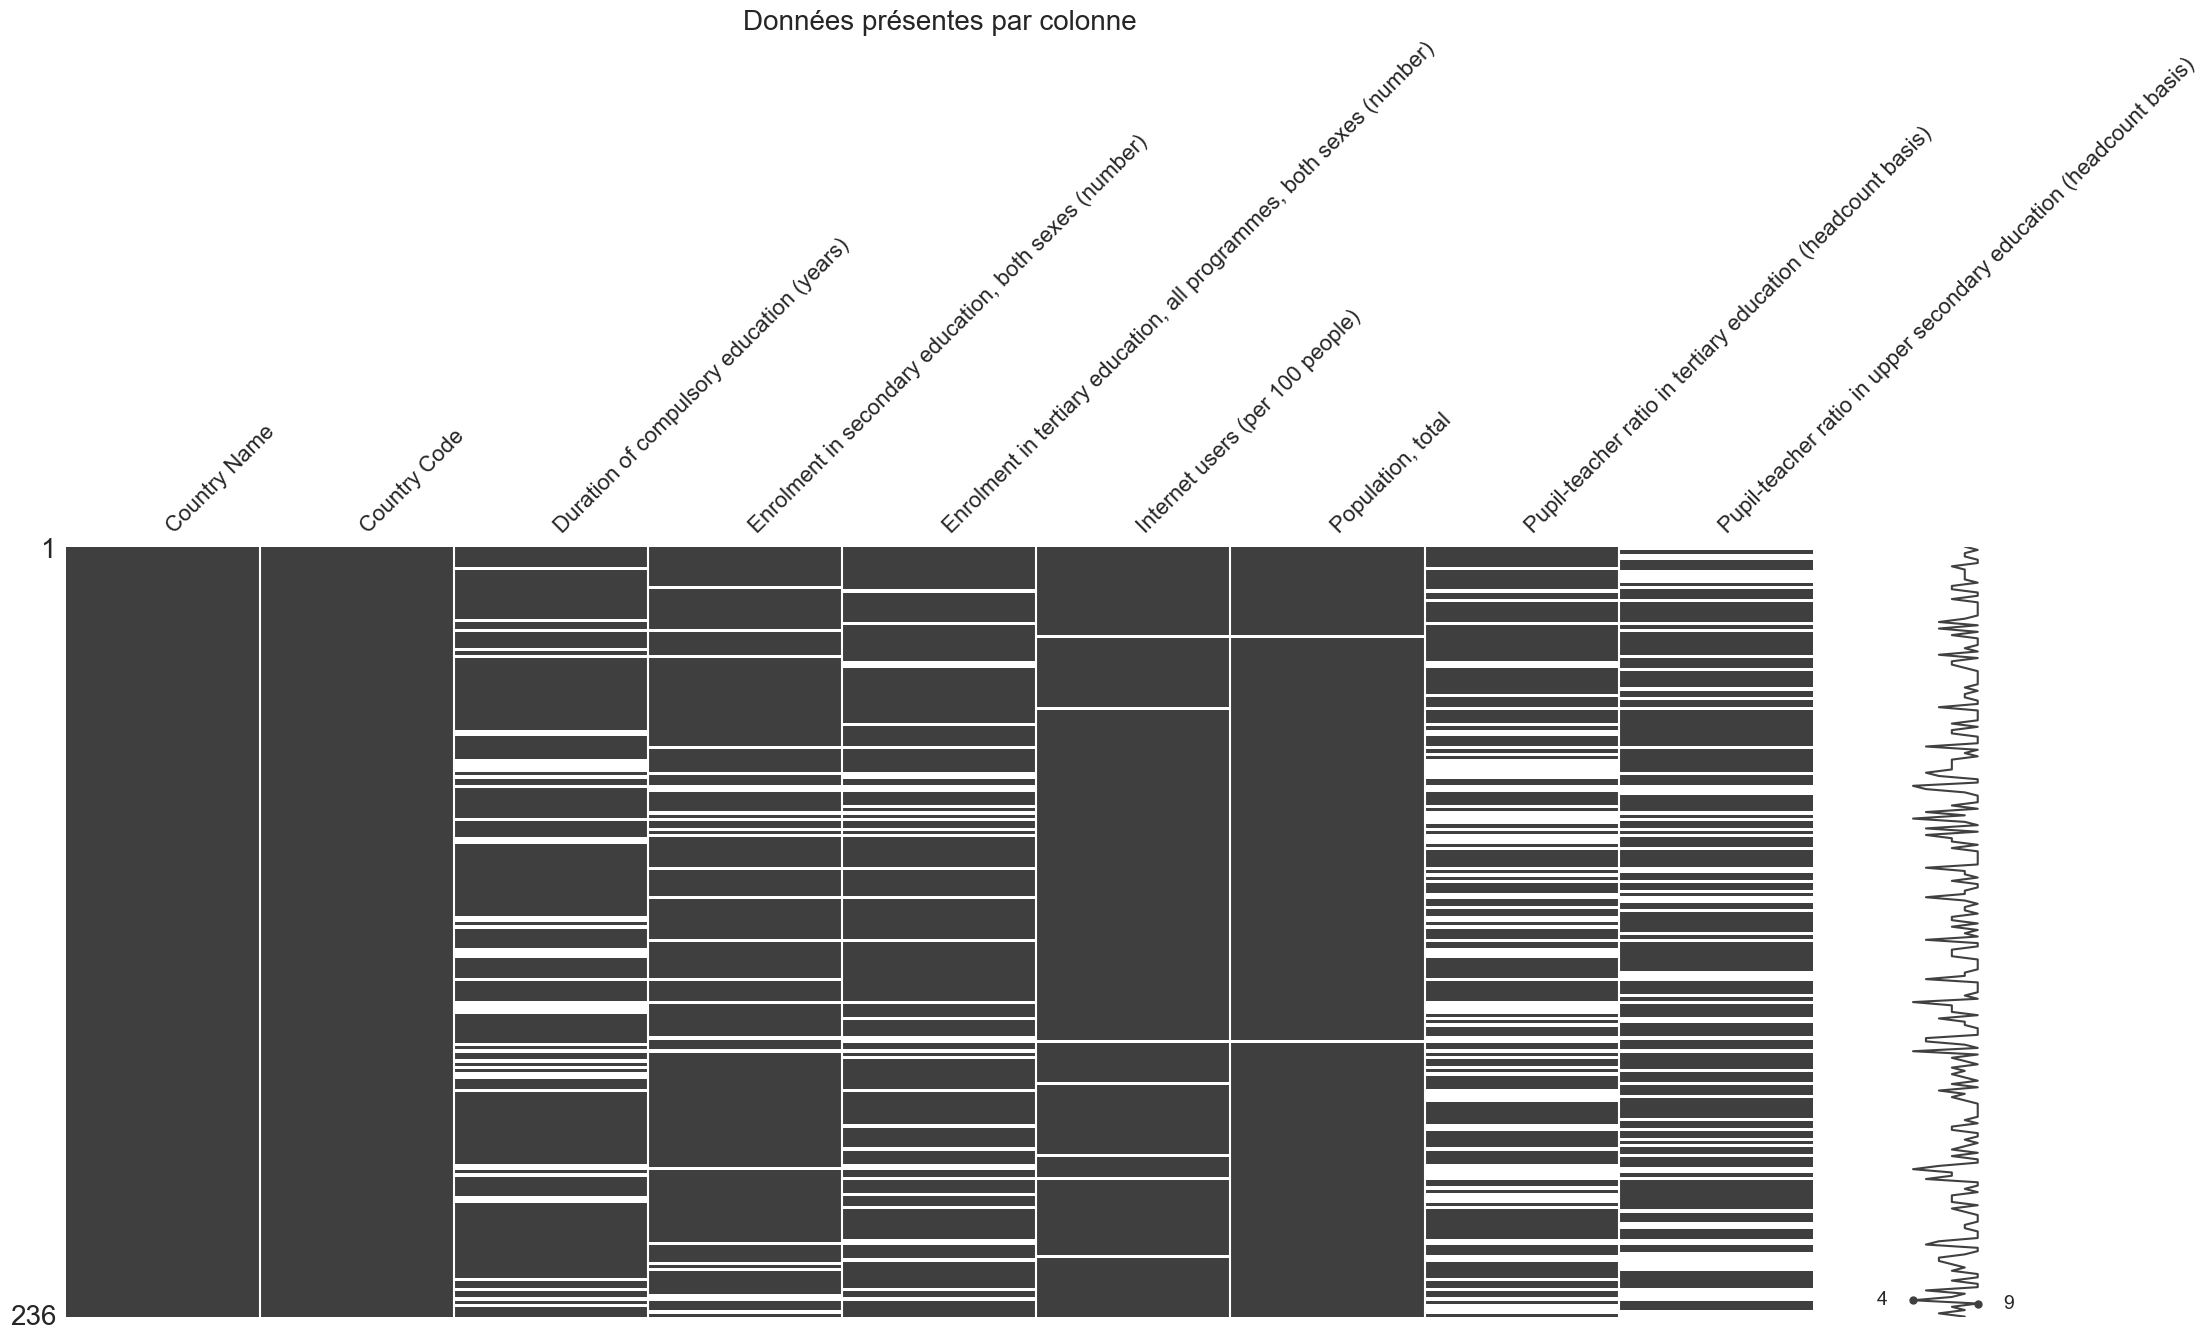

In [55]:
msno.matrix(data_wrk)
plt.title('Données présentes par colonne',fontsize = 20)
plt.show()

Restent à imputer ou filter les données des indicateurs pour lesquels il n'y avait aucune donnée pour la période 2009-2014

#### <a id='toc1_1_5_3_'></a>[Filtre des pays avec une population suffisante pour un développement commercial](#toc0_)

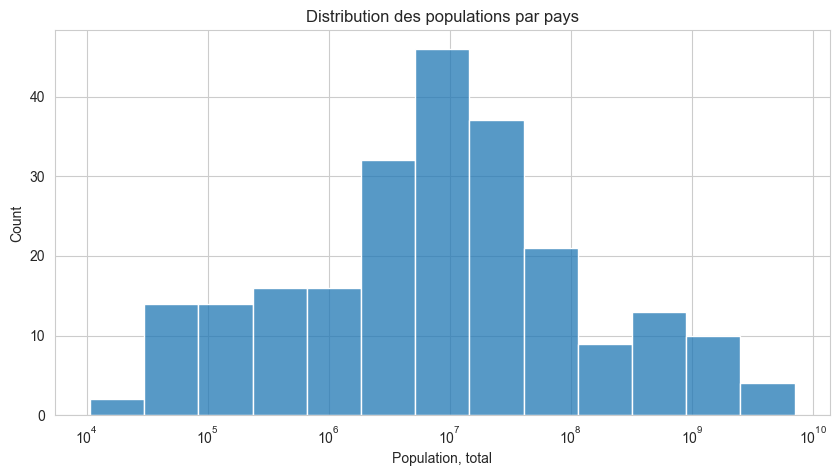

In [56]:
sns.histplot(data=data_wrk,x='Population, total',log_scale=True)
plt.title('Distribution des populations par pays')
plt.show()

In [57]:
data_wrk=data_wrk.loc[data_wrk['Population, total']>1000000]

#### <a id='toc1_1_5_4_'></a>[Filtre sur les lignes représentant un agglomérat de pays ex:World](#toc0_)

In [58]:
country_stats.loc[country_stats['Region'].isna(),['Country Code','Table Name','Region','Income Group']]

,Country Code,Table Name,Region,Income Group
5,ARB,Arab World,NaN,NaN
57,EAP,East Asia & Pacific,NaN,NaN
58,EAS,East Asia & Pacific (all income levels),NaN,NaN
59,ECA,Europe & Central Asia,NaN,NaN
60,ECS,Europe & Central Asia (all income levels),NaN,NaN
63,EMU,Euro area,NaN,NaN
68,EUU,European Union,NaN,NaN
78,GIB,Gibraltar,NaN,NaN
89,HIC,High income,NaN,NaN
92,HPC,Heavily indebted poor countries (HIPC),NaN,NaN


Les "Country Codes" réprésentant des agglomérats de pays peuvent être filtrés avec les "Region" en nan.

In [59]:
data_wrk=data_wrk.merge(
    right=country_stats.loc[:,['Country Code','Region','Income Group']],
    how='left',
    left_on='Country Code',
    right_on='Country Code')
data_wrk

,Country Name,Country Code,Duration of compulsory education (years),"Enrolment in secondary education, both sexes (number)","Enrolment in tertiary education, all programmes, both sexes (number)",Internet users (per 100 people),"Population, total",Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group
0,Afghanistan,AFG,9.0,2.254391e+06,1.518543e+05,5.150758,3.028379e+07,28.090020,NaN,South Asia,Low income
1,Albania,ALB,8.5,3.490902e+05,1.430048e+05,51.192660,2.905055e+06,20.576073,17.576995,Europe & Central Asia,Upper middle income
2,Algeria,DZA,10.0,4.588302e+06,1.198471e+06,18.138333,3.723678e+07,27.088920,NaN,Middle East & North Africa,Upper middle income
3,Angola,AGO,6.0,8.155160e+05,1.807385e+05,5.633333,2.469203e+07,18.160749,20.505810,Sub-Saharan Africa,Upper middle income
4,Arab World,ARB,NaN,3.084011e+07,9.082374e+06,30.062305,3.550503e+08,NaN,12.917909,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
178,West Bank and Gaza,PSE,10.0,7.085805e+05,2.063028e+05,42.396667,3.991910e+06,27.745385,18.443847,Middle East & North Africa,Lower middle income
179,World,WLD,NaN,5.577063e+08,1.918756e+08,32.796923,7.056660e+09,NaN,16.698229,NaN,NaN
180,"Yemen, Rep.",YEM,9.0,1.661876e+06,2.714850e+05,16.201917,2.459442e+07,NaN,24.172729,Middle East & North Africa,Lower middle income
181,Zambia,ZMB,7.0,NaN,5.621950e+04,12.613033,1.450755e+07,NaN,NaN,Sub-Saharan Africa,Lower middle income


In [60]:
data_wrk.dropna(axis=0,subset=['Region'],how='all',inplace=True)


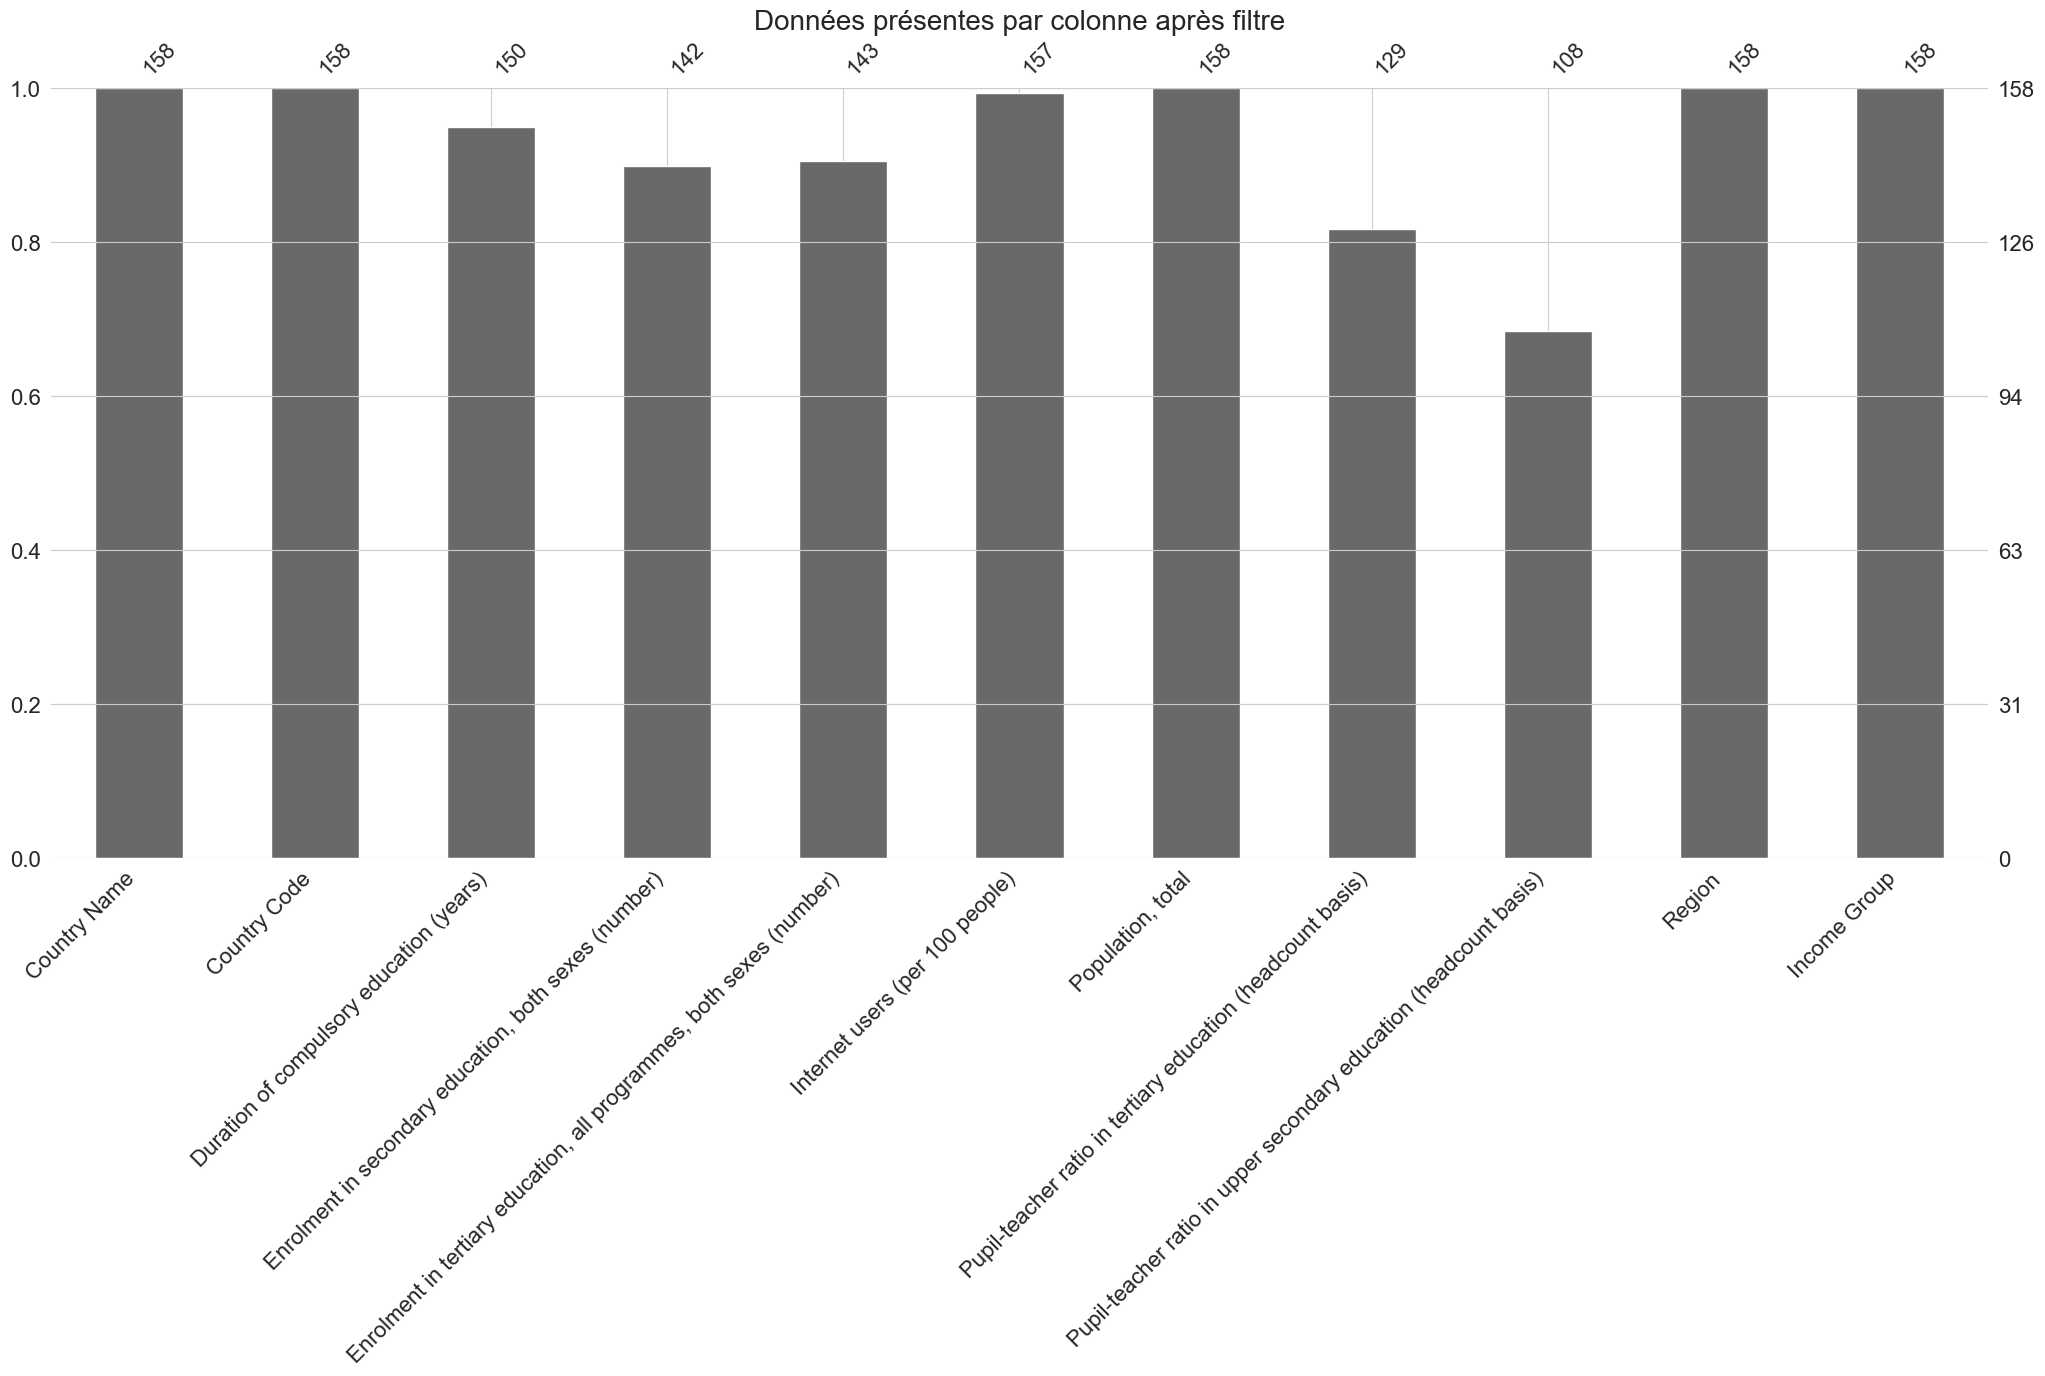

In [61]:
msno.bar(data_wrk)
plt.title('Données présentes par colonne après filtre',fontsize = 20)
plt.show()

In [62]:
data_wrk[data_wrk.isna().any(axis=1)]

,Country Name,Country Code,Duration of compulsory education (years),"Enrolment in secondary education, both sexes (number)","Enrolment in tertiary education, all programmes, both sexes (number)",Internet users (per 100 people),"Population, total",Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group
0,Afghanistan,AFG,9.0,2.254391e+06,1.518543e+05,5.150758,3.028379e+07,28.090020,NaN,South Asia,Low income
2,Algeria,DZA,10.0,4.588302e+06,1.198471e+06,18.138333,3.723678e+07,27.088920,NaN,Middle East & North Africa,Upper middle income
5,Argentina,ARG,13.0,4.300298e+06,2.655461e+06,51.733333,4.188306e+07,16.776770,NaN,Latin America & Caribbean,Upper middle income
6,Armenia,ARM,11.5,2.743640e+05,1.305610e+05,34.387134,2.887188e+06,8.157672,NaN,Europe & Central Asia,Lower middle income
7,Australia,AUS,10.0,2.333144e+06,1.334799e+06,79.365199,2.256163e+07,27.472490,NaN,East Asia & Pacific,High income: OECD
...,...,...,...,...,...,...,...,...,...,...,...
176,"Venezuela, RB",VEN,14.0,2.381836e+06,2.123041e+06,45.206681,2.967133e+07,12.874480,NaN,Latin America & Caribbean,Upper middle income
177,Vietnam,VNM,9.0,NaN,2.204598e+06,34.761667,8.835257e+07,28.309240,NaN,East Asia & Pacific,Lower middle income
180,"Yemen, Rep.",YEM,9.0,1.661876e+06,2.714850e+05,16.201917,2.459442e+07,NaN,24.172729,Middle East & North Africa,Lower middle income
181,Zambia,ZMB,7.0,NaN,5.621950e+04,12.613033,1.450755e+07,NaN,NaN,Sub-Saharan Africa,Lower middle income


#### <a id='toc1_1_5_5_'></a>[Calcul d'indicateurs par % de population pour les indicateurs absolus](#toc0_)

In [63]:
data_wrk['Enrolment in secondary education (per 100 people)']=100*data_wrk['Enrolment in secondary education, both sexes (number)']/data_wrk['Population, total'].round(2)
data_wrk['Enrolment in tertiary education (per 100 people)']=100*data_wrk['Enrolment in tertiary education, all programmes, both sexes (number)']/data_wrk['Population, total'].round(2)

data_wrk.drop(columns=['Enrolment in secondary education, both sexes (number)',
                       'Enrolment in tertiary education, all programmes, both sexes (number)',
                       'Population, total'
                       ],inplace=True)

data_wrk.head()

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
0,Afghanistan,AFG,9.0,5.150758,28.090020,NaN,South Asia,Low income,7.444217,0.501438
1,Albania,ALB,8.5,51.192660,20.576073,17.576995,Europe & Central Asia,Upper middle income,12.016644,4.922620
2,Algeria,DZA,10.0,18.138333,27.088920,NaN,Middle East & North Africa,Upper middle income,12.321962,3.218515
3,Angola,AGO,6.0,5.633333,18.160749,20.505810,Sub-Saharan Africa,Upper middle income,3.302749,0.731971
5,Argentina,ARG,13.0,51.733333,16.776770,NaN,Latin America & Caribbean,Upper middle income,10.267392,6.340179


#### <a id='toc1_1_5_6_'></a>[Recherche des valeurs abhérentes](#toc0_)

In [64]:
data_wrk.describe()

,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
count,150.000000,157.000000,129.000000,108.000000,142.000000,143.000000
mean,9.321111,35.900949,19.568404,16.067486,7.978080,2.944596
std,2.095599,28.052047,9.986328,6.790337,2.487997,1.873387
min,5.000000,0.000000,5.443190,6.768870,1.289039,0.070861
25%,8.125000,10.263333,13.482243,11.066570,6.579885,1.185520
50%,9.000000,33.788333,17.620020,14.907221,7.942783,3.027656
75%,10.250000,57.307599,23.606160,19.556954,9.261552,4.407613
max,14.000000,94.160560,60.009689,36.640337,17.750413,7.155194


La durée de l'enseignement obligatoire à 14 années correspond à la durée de la moyenne section à la terminale.

In [65]:
data_wrk[data_wrk['Internet users (per 100 people)']<1]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
46,Eritrea,ERI,8.0,0.756667,18.488513,36.640337,Sub-Saharan Africa,Low income,5.885880,0.262161
82,"Korea, Dem. People’s Rep.",PRK,11.0,0.000000,8.586590,NaN,East Asia & Pacific,Low income,9.980414,2.407537


In [66]:
data_wrk[data_wrk['Pupil-teacher ratio in tertiary education (headcount basis)']>40]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
23,Cameroon,CMR,6.000000,7.809145,52.087894,19.263651,Sub-Saharan Africa,Lower middle income,8.041041,1.265836
60,Greece,GRC,9.000000,52.766048,40.692551,8.422240,Europe & Central Asia,High income: OECD,6.276677,5.984060
103,Mali,MLI,9.000000,3.216667,52.412720,11.947855,Sub-Saharan Africa,Low income,5.208334,0.543128
104,Mauritania,MRT,6.000000,5.446667,40.358163,17.278139,Sub-Saharan Africa,Lower middle income,3.717422,0.425126
116,Nepal,NPL,NaN,9.798217,60.009689,23.287680,South Asia,Low income,10.443512,1.444860
151,Sri Lanka,LKA,9.000000,16.960900,47.397615,18.020715,South Asia,Lower middle income,12.642730,1.350722
154,Sudan,SDN,7.666667,20.500000,44.720490,15.790360,Sub-Saharan Africa,Lower middle income,4.742401,1.576643
158,Syrian Arab Republic,SYR,9.000000,23.181683,51.322024,8.000600,Middle East & North Africa,Lower middle income,12.722863,3.092075


In [67]:
data_wrk[data_wrk['Pupil-teacher ratio in tertiary education (headcount basis)']<7]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
35,Cuba,CUB,9.000000,20.741246,5.837172,8.411315,Latin America & Caribbean,Upper middle income,7.085233,5.297133
157,Switzerland,CHE,12.000000,84.888838,6.684406,10.946105,Europe & Central Asia,High income: OECD,7.644079,3.305968
167,Turkmenistan,TKM,10.333333,6.490967,5.443190,NaN,Europe & Central Asia,Upper middle income,12.451516,0.849441


In [68]:
data_wrk[data_wrk['Enrolment in secondary education (per 100 people)']<3]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
25,Central African Republic,CAF,10.0,2.666667,32.637210,NaN,Sub-Saharan Africa,Low income,2.573304,0.264936
120,Niger,NER,NaN,1.324617,11.889417,19.292503,Sub-Saharan Africa,Low income,2.149402,0.104932
149,South Sudan,SSD,8.0,NaN,NaN,NaN,Sub-Saharan Africa,Lower middle income,1.289039,NaN


In [69]:
data_wrk[data_wrk['Enrolment in tertiary education (per 100 people)']<0.1]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
101,Malawi,MWI,8.0,3.648433,12.612505,NaN,Sub-Saharan Africa,Low income,4.860744,0.070861


#### <a id='toc1_1_5_7_'></a>[Imputation des données manquantes avec les moyennes sur les pays de la même région et du même "Income Group"](#toc0_)

Imputation pour le premier indicateur : 'Duration of compulsory education (years)'

In [70]:
data_wrk['Duration of compulsory education (years)'].describe()

count    150.000000
mean       9.321111
std        2.095599
min        5.000000
25%        8.125000
50%        9.000000
75%       10.250000
max       14.000000
Name: Duration of compulsory education (years), dtype: float64

In [71]:
data_wrk.groupby(['Region','Income Group'])['Duration of compulsory education (years)'].median()

Region                      Income Group        
East Asia & Pacific         High income: OECD        9.500000
                            High income: nonOECD     7.500000
                            Low income               8.000000
                            Lower middle income      9.000000
                            Upper middle income      9.000000
Europe & Central Asia       High income: OECD       10.000000
                            High income: nonOECD     9.000000
                            Low income               9.000000
                            Lower middle income     10.083333
                            Upper middle income      9.166667
Latin America & Caribbean   High income: OECD       12.333333
                            High income: nonOECD    13.000000
                            Low income               6.000000
                            Lower middle income     10.500000
                            Upper middle income     12.750000
Middle East & North A

In [72]:
data_wrk['Duration of compulsory education (years)'] = data_wrk.groupby(['Region','Income Group'])['Duration of compulsory education (years)'].transform(lambda x: x.fillna(x.median()))
data_wrk

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
0,Afghanistan,AFG,9.0,5.150758,28.090020,NaN,South Asia,Low income,7.444217,0.501438
1,Albania,ALB,8.5,51.192660,20.576073,17.576995,Europe & Central Asia,Upper middle income,12.016644,4.922620
2,Algeria,DZA,10.0,18.138333,27.088920,NaN,Middle East & North Africa,Upper middle income,12.321962,3.218515
3,Angola,AGO,6.0,5.633333,18.160749,20.505810,Sub-Saharan Africa,Upper middle income,3.302749,0.731971
5,Argentina,ARG,13.0,51.733333,16.776770,NaN,Latin America & Caribbean,Upper middle income,10.267392,6.340179
...,...,...,...,...,...,...,...,...,...,...
177,Vietnam,VNM,9.0,34.761667,28.309240,NaN,East Asia & Pacific,Lower middle income,NaN,2.495228
178,West Bank and Gaza,PSE,10.0,42.396667,27.745385,18.443847,Middle East & North Africa,Lower middle income,17.750413,5.168023
180,"Yemen, Rep.",YEM,9.0,16.201917,NaN,24.172729,Middle East & North Africa,Lower middle income,6.757127,1.103848
181,Zambia,ZMB,7.0,12.613033,NaN,NaN,Sub-Saharan Africa,Lower middle income,NaN,0.387519


In [73]:
data_wrk['Duration of compulsory education (years)'].describe()

count    158.000000
mean       9.266878
std        2.060475
min        5.000000
25%        8.000000
50%        9.000000
75%       10.000000
max       14.000000
Name: Duration of compulsory education (years), dtype: float64

In [74]:
data_wrk[data_wrk['Duration of compulsory education (years)'].isna()]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)


Imputation des autres indicateurs :

In [75]:
for col in data_wrk.select_dtypes(float).columns :
    data_wrk.loc[:,col] = data_wrk.groupby(['Region','Income Group'])[col].transform(lambda x: x.fillna(x.median()))


c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet2-Areo7Kbk-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet2-Areo7Kbk-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet2-Areo7Kbk-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet2-Areo7Kbk-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\blanc\AppData\Local\pypoetry\Cache\virtualenvs\projet2-Areo7Kbk-py3.11\Lib\site-packages\numpy\lib\

In [76]:
data_wrk.isna().sum()

Country Name                                                          0
Country Code                                                          0
Duration of compulsory education (years)                              0
Internet users (per 100 people)                                       0
Pupil-teacher ratio in tertiary education (headcount basis)           3
Pupil-teacher ratio in upper secondary education (headcount basis)    3
Region                                                                0
Income Group                                                          0
Enrolment in secondary education (per 100 people)                     2
Enrolment in tertiary education (per 100 people)                      2
dtype: int64

Traitement des cas particuliers (pays sans données dans leur catégorie)

In [77]:
data_wrk[data_wrk.isna().any(axis=1)]

,Country Name,Country Code,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Region,Income Group,Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
45,Equatorial Guinea,GNQ,6.0,11.472197,NaN,NaN,Sub-Saharan Africa,High income: nonOECD,NaN,NaN
64,Haiti,HTI,6.0,9.545000,NaN,NaN,Latin America & Caribbean,Low income,NaN,NaN
75,Israel,ISR,13.0,69.260324,NaN,9.380735,Middle East & North Africa,High income: OECD,9.296279,4.671552
159,Tajikistan,TJK,9.0,13.775000,15.069407,NaN,Europe & Central Asia,Low income,13.191911,2.478565


Pour Equatorial Guinea et Haiti, il manque 4 indicateurs non imputables avec les régions et les groupes de revenus. Ces deux pays ne seront pas pris en compte pour l'analyse.
Israel et Tajikistan ont un seul indicateur manquant qui sera estimé.

In [78]:
data_wrk=data_wrk.loc[data_wrk['Country Name']!='Equatorial Guinea']
data_wrk=data_wrk.loc[data_wrk['Country Name']!='Haiti']

In [79]:
data_wrk.groupby(['Region','Income Group'])['Pupil-teacher ratio in tertiary education (headcount basis)'].mean()

Region                      Income Group        
East Asia & Pacific         High income: OECD       16.550711
                            High income: nonOECD    13.670928
                            Low income              18.721642
                            Lower middle income     20.217459
                            Upper middle income     18.913074
Europe & Central Asia       High income: OECD       15.863096
                            High income: nonOECD    12.568393
                            Low income              15.069407
                            Lower middle income     11.783514
                            Upper middle income     16.965482
Latin America & Caribbean   High income: OECD       14.712010
                            High income: nonOECD    11.989908
                            Lower middle income     18.812068
                            Upper middle income     14.512026
Middle East & North Africa  High income: OECD             NaN
                     

L'indicateur pour Israel sera estimé avec la moyenne des pays de même revenu et région mais pas membres de l'OECD (Organisation for Economic Co- operation and Development).

In [80]:
moyenne_Israel=data_wrk[
    (data_wrk['Region']=='Middle East & North Africa')
    &(data_wrk['Income Group']=='High income: nonOECD')
    ]['Pupil-teacher ratio in tertiary education (headcount basis)'].mean()
moyenne_Israel

17.19238556226094

In [81]:
data_wrk.loc[data_wrk['Country Name']=='Israel','Pupil-teacher ratio in tertiary education (headcount basis)']=moyenne_Israel

L'indicateur pour Tajikistan sera estimé avec la moyenne des pays de même région et de catégorie de revenu un cran supérieur (Lower middle income au lieu de Low income)

In [82]:
data_wrk.groupby(['Region','Income Group'])['Pupil-teacher ratio in upper secondary education (headcount basis)'].mean()

Region                      Income Group        
East Asia & Pacific         High income: OECD       13.362048
                            High income: nonOECD    14.905090
                            Low income              26.911457
                            Lower middle income     22.606489
                            Upper middle income     17.053709
Europe & Central Asia       High income: OECD       11.344098
                            High income: nonOECD     8.729735
                            Low income                    NaN
                            Lower middle income     11.646660
                            Upper middle income     12.831192
Latin America & Caribbean   High income: OECD       20.964090
                            High income: nonOECD    12.975844
                            Lower middle income     18.701688
                            Upper middle income     16.261085
Middle East & North Africa  High income: OECD        9.380735
                     

In [83]:
moyenne_Tajikistan=data_wrk[
    (data_wrk['Region']=='Europe & Central Asia')
    &(data_wrk['Income Group']=='Lower middle income')
    ]['Pupil-teacher ratio in upper secondary education (headcount basis)'].mean()
moyenne_Tajikistan

11.64666006300183

In [84]:
data_wrk.loc[data_wrk['Country Name']=='Tajikistan','Pupil-teacher ratio in upper secondary education (headcount basis)']=moyenne_Tajikistan

In [85]:
data_wrk.isna().sum()

Country Name                                                          0
Country Code                                                          0
Duration of compulsory education (years)                              0
Internet users (per 100 people)                                       0
Pupil-teacher ratio in tertiary education (headcount basis)           0
Pupil-teacher ratio in upper secondary education (headcount basis)    0
Region                                                                0
Income Group                                                          0
Enrolment in secondary education (per 100 people)                     0
Enrolment in tertiary education (per 100 people)                      0
dtype: int64

### <a id='toc1_1_6_'></a>[Visualisation des données](#toc0_)

In [86]:
liste_indicateurs=['Duration of compulsory education (years)',
                   'Internet users (per 100 people)',
                   'Pupil-teacher ratio in tertiary education (headcount basis)',
                   'Pupil-teacher ratio in upper secondary education (headcount basis)',
                   'Enrolment in secondary education (per 100 people)',
                   'Enrolment in tertiary education (per 100 people)']

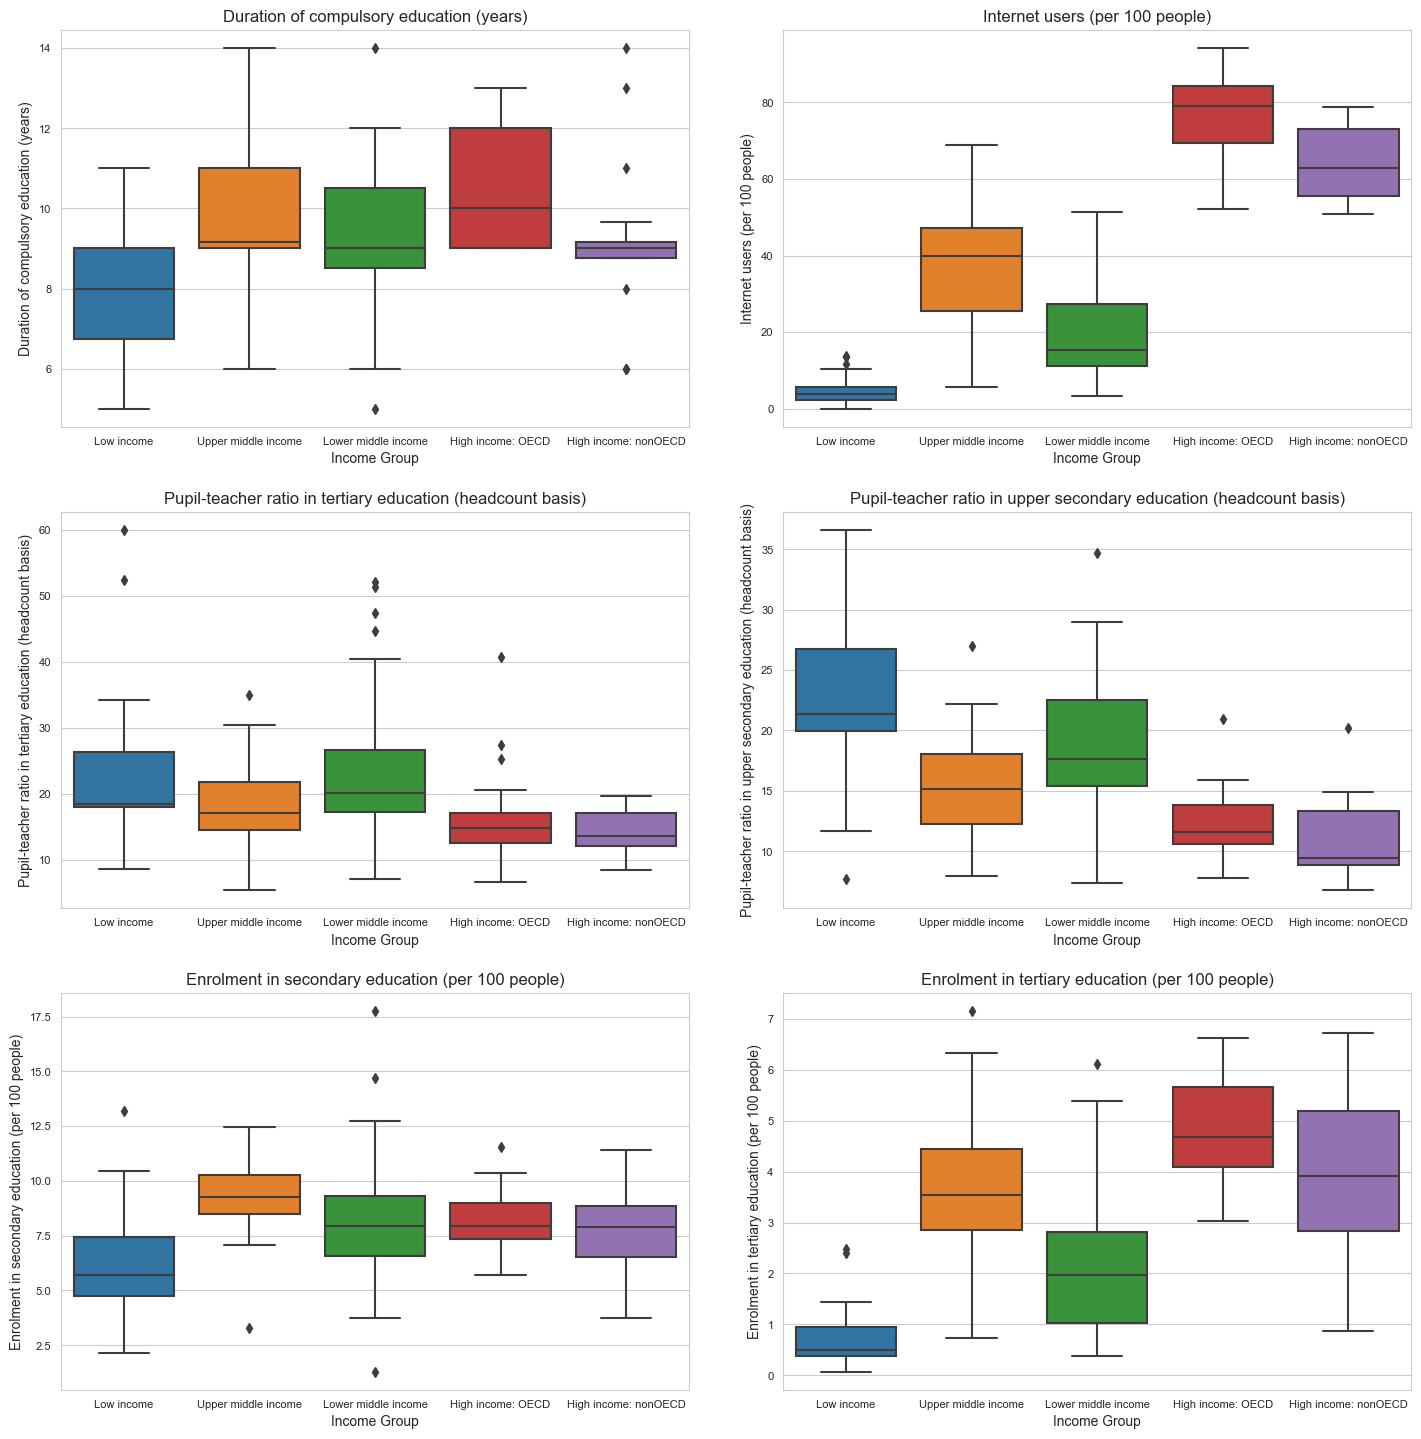

In [87]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(15, 15),sharex=False)
fig.tight_layout(pad=4.0)
for ax, col in zip(axs.ravel(),liste_indicateurs):
    sns.boxplot(data=data_wrk,x='Income Group',y=col,ax=ax,showfliers=True)
    ax.set_title(col,size=12)
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.tick_params(labelsize=8)
plt.show()    

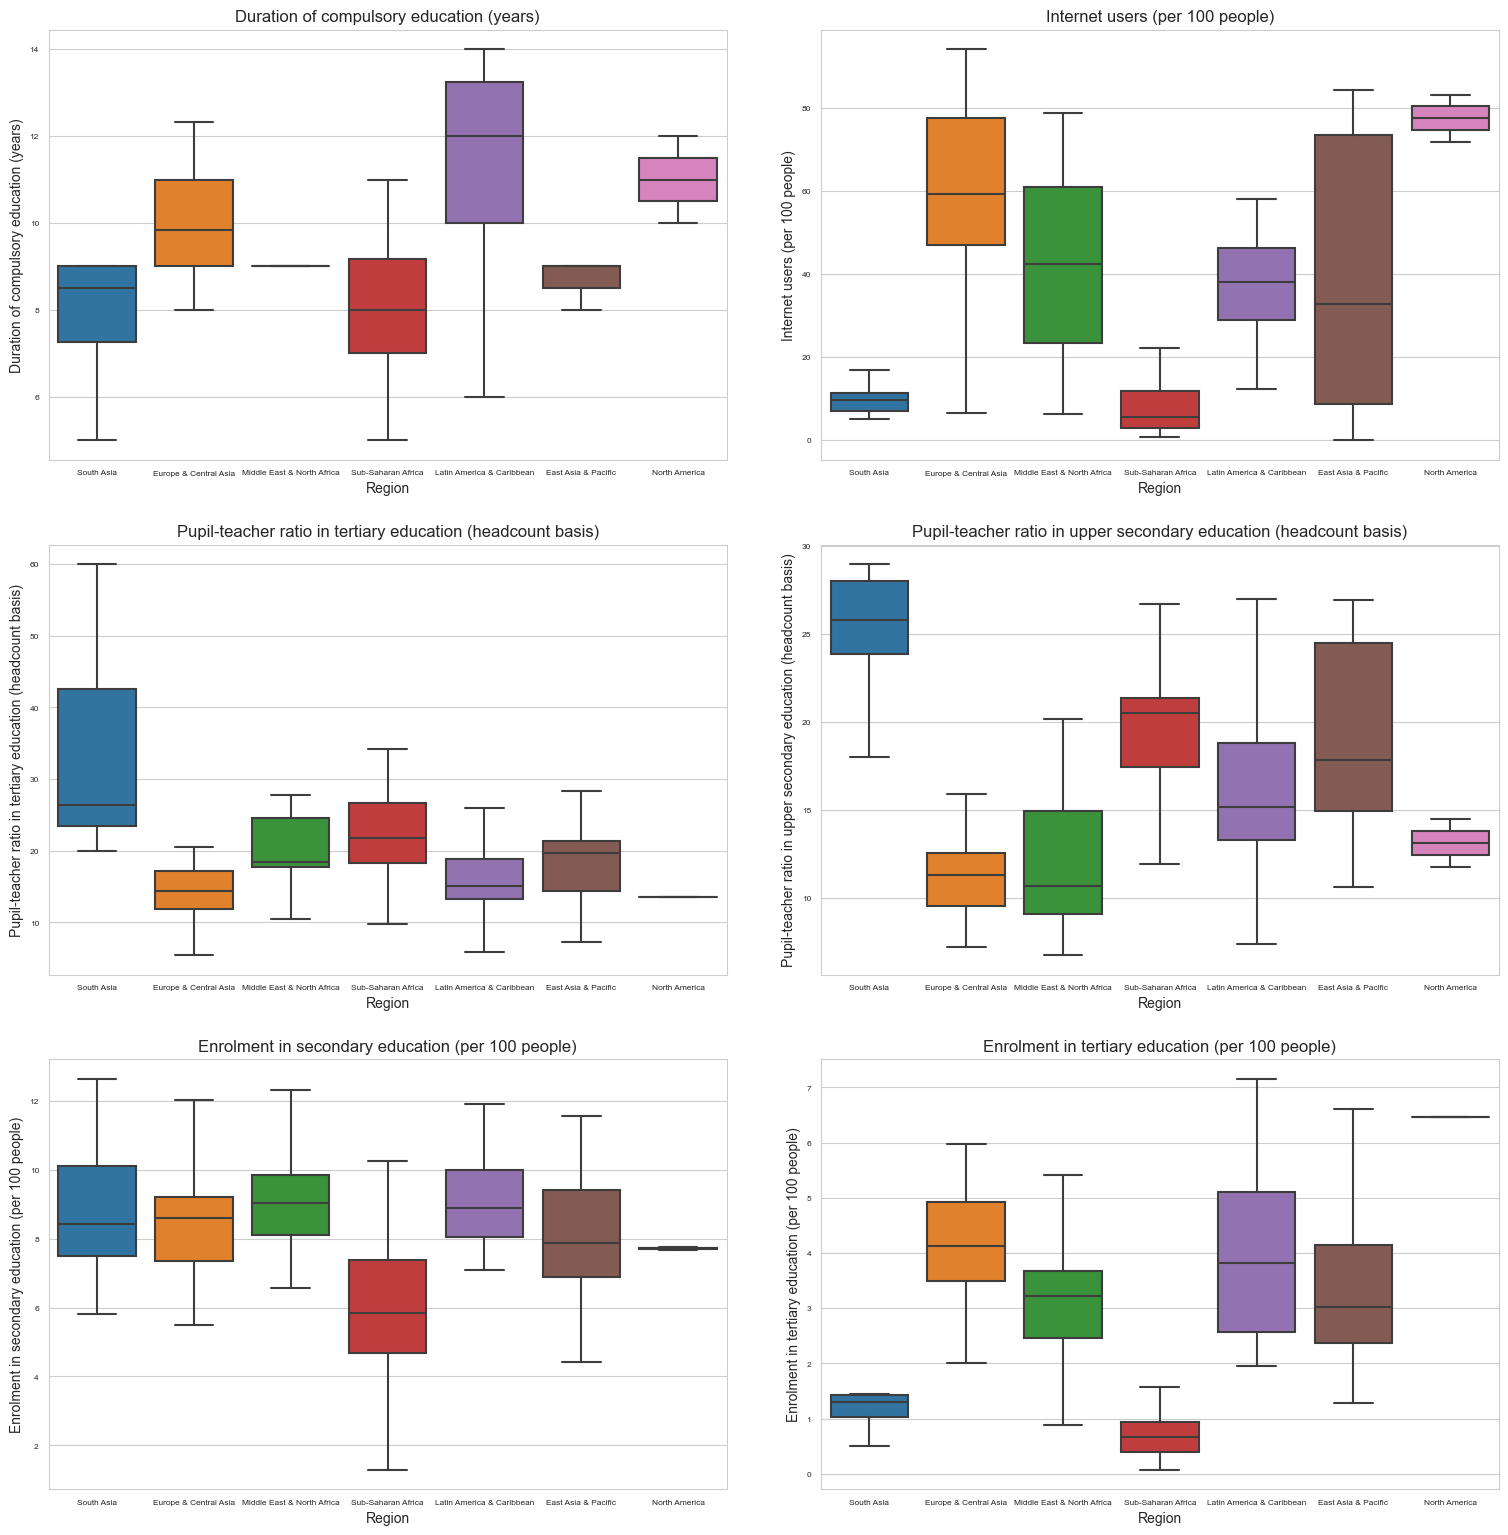

In [88]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(16, 16),sharex=False)
fig.tight_layout(pad=4.0)
for ax, col in zip(axs.ravel(),liste_indicateurs):
    sns.boxplot(data=data_wrk,x='Region',y=col,ax=ax,showfliers=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(col,size=12)
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.tick_params(labelsize=6)
plt.show()  

In [89]:
stats={}
for indicateur in liste_indicateurs:
    stats[indicateur]=data_wrk.groupby('Region')[indicateur].describe().round(1)
    print(indicateur)
    display(stats[indicateur])

Duration of compulsory education (years)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,8.6,1.9,5.0,8.5,9.0,9.0,12.0
Europe & Central Asia,45.0,10.0,1.2,8.0,9.0,9.8,11.0,12.3
Latin America & Caribbean,22.0,11.4,2.6,6.0,10.0,12.0,13.2,14.0
Middle East & North Africa,19.0,9.0,1.5,6.0,9.0,9.0,9.0,13.0
North America,2.0,11.0,1.4,10.0,10.5,11.0,11.5,12.0
South Asia,6.0,8.3,2.3,5.0,7.2,8.5,9.0,12.0
Sub-Saharan Africa,43.0,8.1,1.6,5.0,7.0,8.0,9.2,11.0


Internet users (per 100 people)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,38.2,32.2,0.0,8.7,32.8,73.6,84.2
Europe & Central Asia,45.0,59.6,22.0,6.5,47.1,59.2,77.6,94.2
Latin America & Caribbean,22.0,36.9,13.9,12.4,28.9,38.1,46.3,58.2
Middle East & North Africa,19.0,43.1,22.9,6.3,23.3,42.4,61.1,78.9
North America,2.0,77.6,8.0,71.9,74.8,77.6,80.4,83.3
South Asia,6.0,9.9,4.3,5.2,7.0,9.7,11.4,17.0
Sub-Saharan Africa,43.0,8.7,8.0,0.8,3.0,5.6,11.8,34.4


Pupil-teacher ratio in tertiary education (headcount basis)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,18.3,5.8,7.2,14.3,19.7,21.4,28.3
Europe & Central Asia,45.0,15.2,6.8,5.4,11.9,14.4,17.1,40.7
Latin America & Caribbean,22.0,15.3,4.5,5.8,13.3,15.1,18.8,25.9
Middle East & North Africa,19.0,21.2,8.9,7.4,17.7,18.5,24.6,51.3
North America,2.0,13.5,0.0,13.5,13.5,13.5,13.5,13.5
South Asia,6.0,33.9,16.1,19.9,23.4,26.4,42.6,60.0
Sub-Saharan Africa,43.0,23.8,9.7,9.7,18.3,21.8,26.7,52.4


Pupil-teacher ratio in upper secondary education (headcount basis)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,19.7,5.5,10.6,14.9,17.8,24.5,26.9
Europe & Central Asia,45.0,11.5,2.6,7.2,9.6,11.3,12.5,17.9
Latin America & Caribbean,22.0,16.7,6.1,7.4,13.3,15.2,18.8,34.7
Middle East & North Africa,19.0,12.2,5.0,6.8,9.1,10.7,14.9,24.2
North America,2.0,13.1,1.9,11.8,12.4,13.1,13.8,14.5
South Asia,6.0,25.1,4.1,18.0,23.9,25.8,28.0,29.0
Sub-Saharan Africa,43.0,20.6,5.2,7.7,17.5,20.5,21.4,36.6


Enrolment in secondary education (per 100 people)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,7.9,1.9,4.4,6.9,7.9,9.4,11.6
Europe & Central Asia,45.0,8.7,1.9,5.5,7.4,8.6,9.2,14.7
Latin America & Caribbean,22.0,9.1,1.3,7.1,8.0,8.9,10.0,11.9
Middle East & North Africa,19.0,9.3,2.9,3.8,8.1,9.0,9.8,17.8
North America,2.0,7.7,0.0,7.7,7.7,7.7,7.7,7.7
South Asia,6.0,8.9,2.4,5.8,7.5,8.4,10.1,12.6
Sub-Saharan Africa,43.0,5.9,2.1,1.3,4.7,5.8,7.4,10.3


Enrolment in tertiary education (per 100 people)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,19.0,3.4,1.7,1.3,2.4,3.0,4.1,6.6
Europe & Central Asia,45.0,4.1,1.2,0.8,3.5,4.1,4.9,6.0
Latin America & Caribbean,22.0,4.1,1.6,1.9,2.6,3.8,5.1,7.2
Middle East & North Africa,19.0,3.1,1.3,0.9,2.5,3.2,3.7,5.4
North America,2.0,6.5,0.0,6.5,6.5,6.5,6.5,6.5
South Asia,6.0,1.3,0.5,0.5,1.0,1.3,1.4,2.0
Sub-Saharan Africa,43.0,0.8,0.6,0.1,0.4,0.7,0.9,3.0


### <a id='toc1_1_7_'></a>[Calcul d'un score global par pays](#toc0_)

#### <a id='toc1_1_7_1_'></a>[Méthode : moyenne non pondérée des indicateurs normalisés](#toc0_)

Pour l'ensemble des indicateurs, une valeur élévée doit se traduire par un fort score :
- Duration of compulsory education (years), Enrolment in secondary education et Enrolment in tertiary education sont des indicateurs de la part de population pouvant être intéressée par ce produit. Plus ces indicateurs prennent des valeurs élevées, plus le score de potentiel de développement du produit est important.

- Internet users transcrit la population pouvant se connecter sur la plateforme. De même que pour les indicateurs précédents, les valeurs élevées soivent se traduire par un score important.

- Pupil-teacher ratio traduit la disponibilité des enseignants. L'hypothèse est que plus ce ratio est élévé, plus les étudiants ont des difficultés à avoir un suivi personnalisé et plus ils peuvent être demandeurs d'aides à l'étude sous la forme par exemple de cours en ligne.

In [90]:
data_wrk.index=data_wrk['Country Name']
scores=data_wrk.drop(columns=['Country Name','Country Code','Region','Income Group'])
scores

,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
Country Name,,,,,,
Afghanistan,9.0,5.150758,28.090020,25.982059,7.444217,0.501438
Albania,8.5,51.192660,20.576073,17.576995,12.016644,4.922620
Algeria,10.0,18.138333,27.088920,10.680117,12.321962,3.218515
Angola,6.0,5.633333,18.160749,20.505810,3.302749,0.731971
Argentina,13.0,51.733333,16.776770,15.150395,10.267392,6.340179
...,...,...,...,...,...,...
Vietnam,9.0,34.761667,28.309240,23.776430,8.210947,2.495228
West Bank and Gaza,10.0,42.396667,27.745385,18.443847,17.750413,5.168023
"Yemen, Rep.",9.0,16.201917,26.113833,24.172729,6.757127,1.103848


In [91]:
scaler=StandardScaler()
columns=scores.columns
index=scores.index

scores=pd.DataFrame(scaler.fit_transform(scores))
scores.columns=columns
scores.index=index

scores.describe().round(1)


,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people)
count,156.0,156.0,156.0,156.0,156.0,156.0
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.1,-1.3,-1.5,-1.5,-2.8,-1.5
25%,-0.6,-0.9,-0.6,-0.8,-0.6,-0.9
50%,-0.2,-0.1,-0.1,-0.2,0.0,0.0
75%,0.3,0.8,0.4,0.7,0.5,0.7
max,2.3,2.1,4.4,3.2,4.1,2.3


In [92]:
scores['score']=scores.mean(axis=1)
scores

,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people),score
Country Name,,,,,,,
Afghanistan,-0.151854,-1.105212,0.944967,1.534055,-0.217849,-1.287976,-0.047312
Albania,-0.397763,0.540677,0.126884,0.192066,1.679765,1.078960,0.536765
Algeria,0.339964,-0.640937,0.835972,-0.909120,1.806475,0.166645,0.266500
Angola,-1.627310,-1.087961,-0.136085,0.659693,-1.936609,-1.164558,-0.882138
Argentina,1.815420,0.560004,-0.286767,-0.195376,0.953804,1.837868,0.780826
...,...,...,...,...,...,...,...
Vietnam,-0.151854,-0.046692,0.968834,1.181895,0.100354,-0.220576,0.305327
West Bank and Gaza,0.339964,0.226241,0.907444,0.330471,4.059349,1.210340,1.178968
"Yemen, Rep.",-0.151854,-0.710159,0.729809,1.245170,-0.503000,-0.965468,-0.059251


Text(0.5, 1.0, 'Distribution des scores')

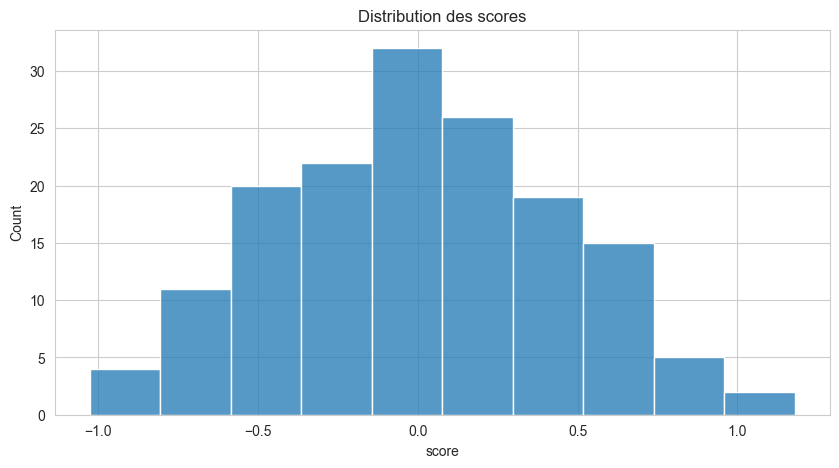

In [93]:
sns.histplot(scores['score'])
plt.title('Distribution des scores')

In [94]:
scores.sort_values('score',ascending=False,inplace=True)
print('Top 10 :')
display(scores.head(10))
print('Bottom 10 :')
display(scores.tail(10))

Top 10 :


,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people),score
Country Name,,,,,,,
West Bank and Gaza,0.339964,0.226241,0.907444,0.330471,4.059349,1.210340,1.178968
Dominican Republic,2.307238,0.110299,0.709674,1.695401,0.459114,0.836009,1.019623
Turkey,0.339964,0.269887,1.696314,0.248348,1.530992,1.463587,0.924849
Australia,0.339964,1.547778,0.877733,-0.406782,0.984437,1.610903,0.825672
Argentina,1.815420,0.560004,-0.286767,-0.195376,0.953804,1.837868,0.780826
Mongolia,1.323601,-0.772533,0.033740,1.181895,1.017150,1.719418,0.750545
Brazil,2.307238,0.377161,-0.012845,-0.191288,1.641254,0.341356,0.743813
Chile,1.487541,0.575314,-0.511568,0.732864,0.350777,1.770535,0.734244
New Zealand,0.339964,1.637882,-0.285847,-0.406782,1.486431,1.624721,0.732728


Bottom 10 :


,Duration of compulsory education (years),Internet users (per 100 people),Pupil-teacher ratio in tertiary education (headcount basis),Pupil-teacher ratio in upper secondary education (headcount basis),Enrolment in secondary education (per 100 people),Enrolment in tertiary education (per 100 people),score
Country Name,,,,,,,
Burkina Faso,0.339964,-1.118019,-0.103666,-0.051390,-1.660718,-1.357967,-0.658633
Liberia,-1.627310,-1.182037,0.394557,0.141325,-0.984988,-1.053213,-0.718611
"Congo, Dem. Rep.",-1.627310,-1.233573,-0.194957,0.796100,-0.971526,-1.197954,-0.738203
South Sudan,-0.643673,-0.890753,0.789452,0.172683,-2.772323,-1.086445,-0.738510
Malawi,-0.643673,-1.158917,-0.740152,0.796100,-1.290022,-1.518491,-0.759192
Chad,0.339964,-1.214269,-1.053291,0.479220,-1.842622,-1.439494,-0.788415
Benin,-1.627310,-1.140878,-0.120327,-1.390750,0.278526,-0.914590,-0.819221
Madagascar,-2.119128,-1.204558,-0.124396,0.595120,-0.845120,-1.342558,-0.840107
Angola,-1.627310,-1.087961,-0.136085,0.659693,-1.936609,-1.164558,-0.882138


##### <a id='toc1_1_7_1_1_'></a>[Visualisations des scores](#toc0_)

Visualisation de la contribution de chaque indicateur au score global

In [95]:
fig = go.Figure()
fig.update_layout(title='Contribution of each indicator to the global score : (zoom to explore)',
                  width=1150, 
                  height=1000,
                  xaxis_title="Score",
                  yaxis_title="Country",)

for col in scores.columns[:-1]:
    fig.add_trace(go.Bar(
        y=scores.index,
        x=scores[col]/6,
        name=col,
        orientation='h'))

fig.show()

In [96]:
top=scores.head(10)
top['Label']=top.index+' : '+top['score'].round(2).astype(str)
fig = go.Figure()
fig.update_layout(title='Contribution of each indicator to the global score for top 10 countries',
                  width=1150, 
                  height=700,
                  xaxis_title="Contribution of each indicator",
                  yaxis_title="Country and total score",)

for col in scores.columns[:-1]:
    fig.add_trace(go.Bar(
        y=top['Label'],
        x=(top[col]/6).round(2),
        name=col,
        orientation='h'))

fig.show()


C:\Users\blanc\AppData\Local\Temp\ipykernel_5412\1046238570.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
bottom=scores.tail(10)
bottom['Label']=bottom.index+' : '+bottom['score'].round(2).astype(str)
fig = go.Figure()
fig.update_layout(title='Contribution of each indicator to the global score for bottom 10 countries',
                  width=1150, 
                  height=700,
                  xaxis_title="Contribution of each indicator",
                  yaxis_title="Country and total score",)

for col in scores.columns[:-1]:
    fig.add_trace(go.Bar(
        y=bottom['Label'],
        x=(bottom[col]/6).round(2),
        name=col,
        orientation='h'))

fig.show()

C:\Users\blanc\AppData\Local\Temp\ipykernel_5412\1998750235.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Visualisation des la répartition des indicateurs

In [98]:
for ax, col in zip(axs.ravel(),liste_indicateurs):
    sns.boxplot(data=data_wrk,x='Income Group',y=col,ax=ax,showfliers=True)
    ax.set_title(col,size=12)
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.tick_params(labelsize=8)
plt.show()  

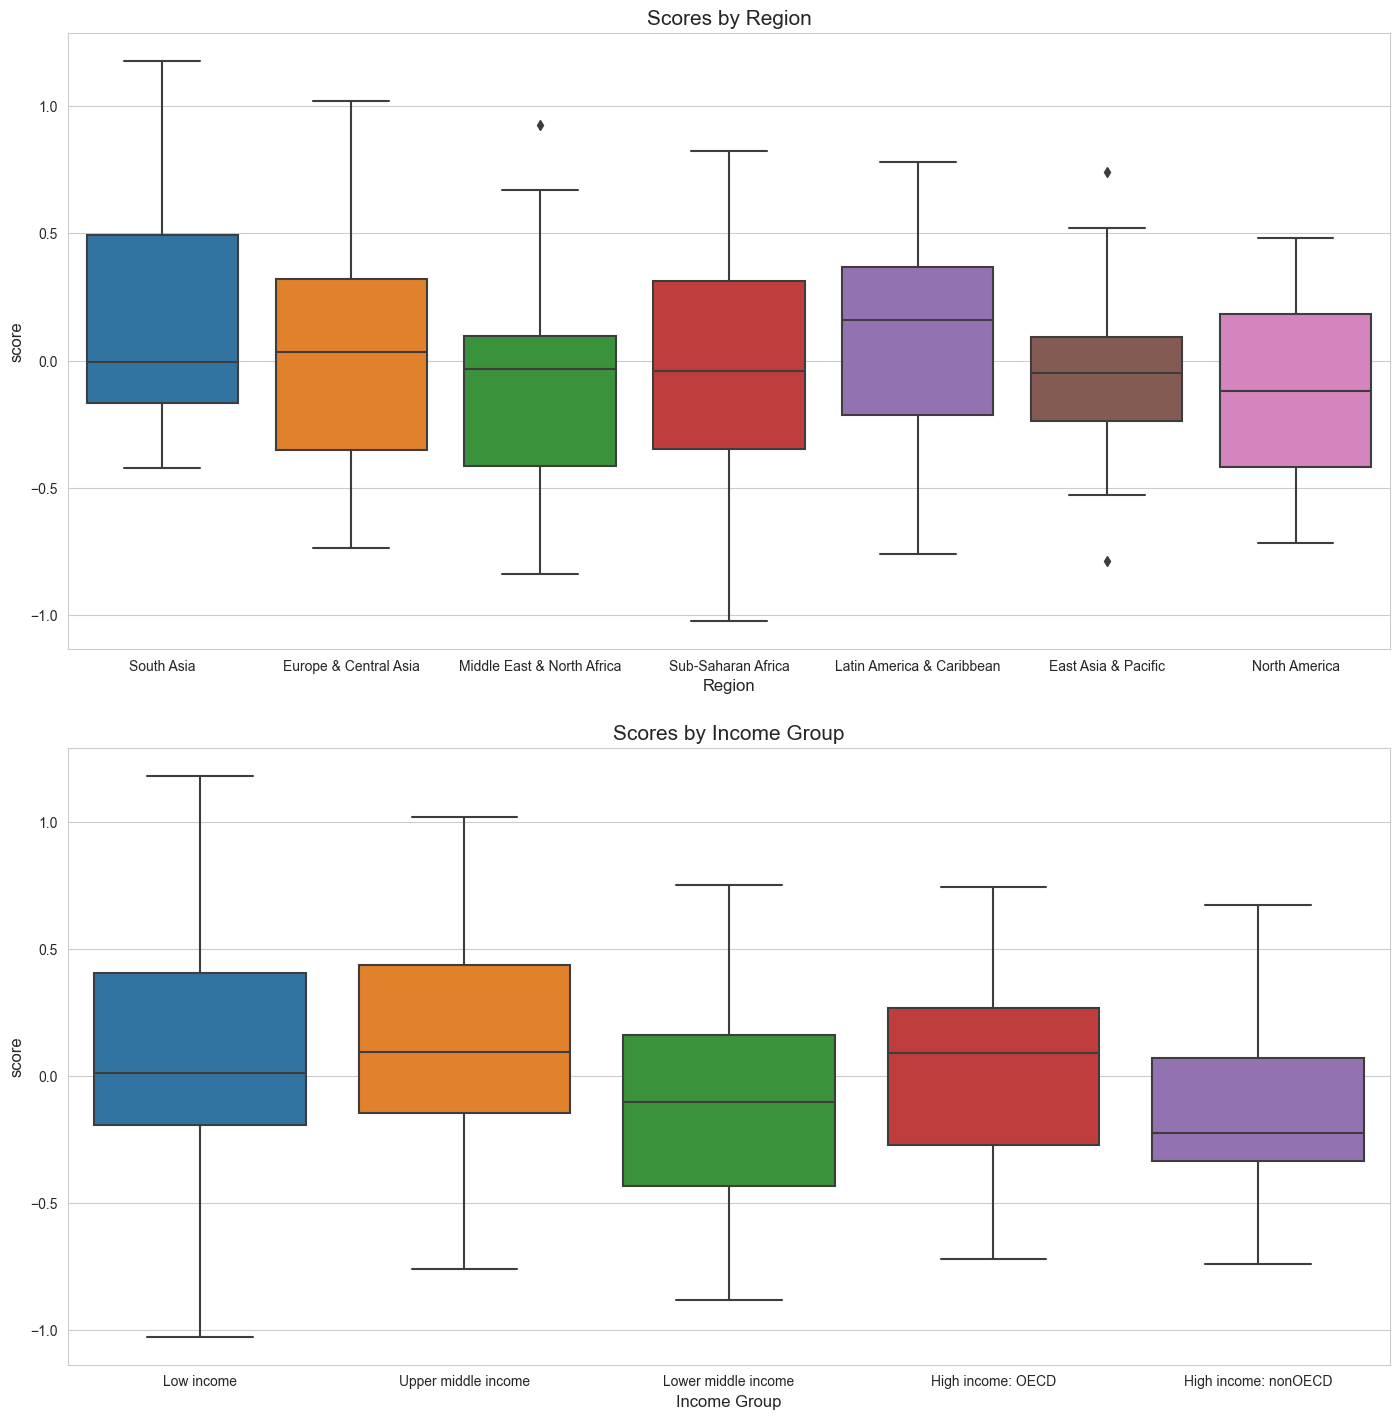

In [99]:
df_temp=pd.merge(left=scores,right=data_wrk[['Country Name','Region','Income Group']],on=index)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15, 15),sharex=False)
fig.tight_layout(pad=5.0)

sns.boxplot(data=df_temp,x='Region',y='score',showfliers=True,ax=axs[0])
axs[0].set_title('Scores by Region',size=15)
axs[0].yaxis.label.set_size(12)
axs[0].xaxis.label.set_size(12)
axs[0].tick_params(labelsize=10)

sns.boxplot(data=df_temp,x='Income Group',y='score',showfliers=True,ax=axs[1])
axs[1].set_title('Scores by Income Group',size=15)
axs[1].yaxis.label.set_size(12)
axs[1].xaxis.label.set_size(12)
axs[1].tick_params(labelsize=10)
plt.show()  

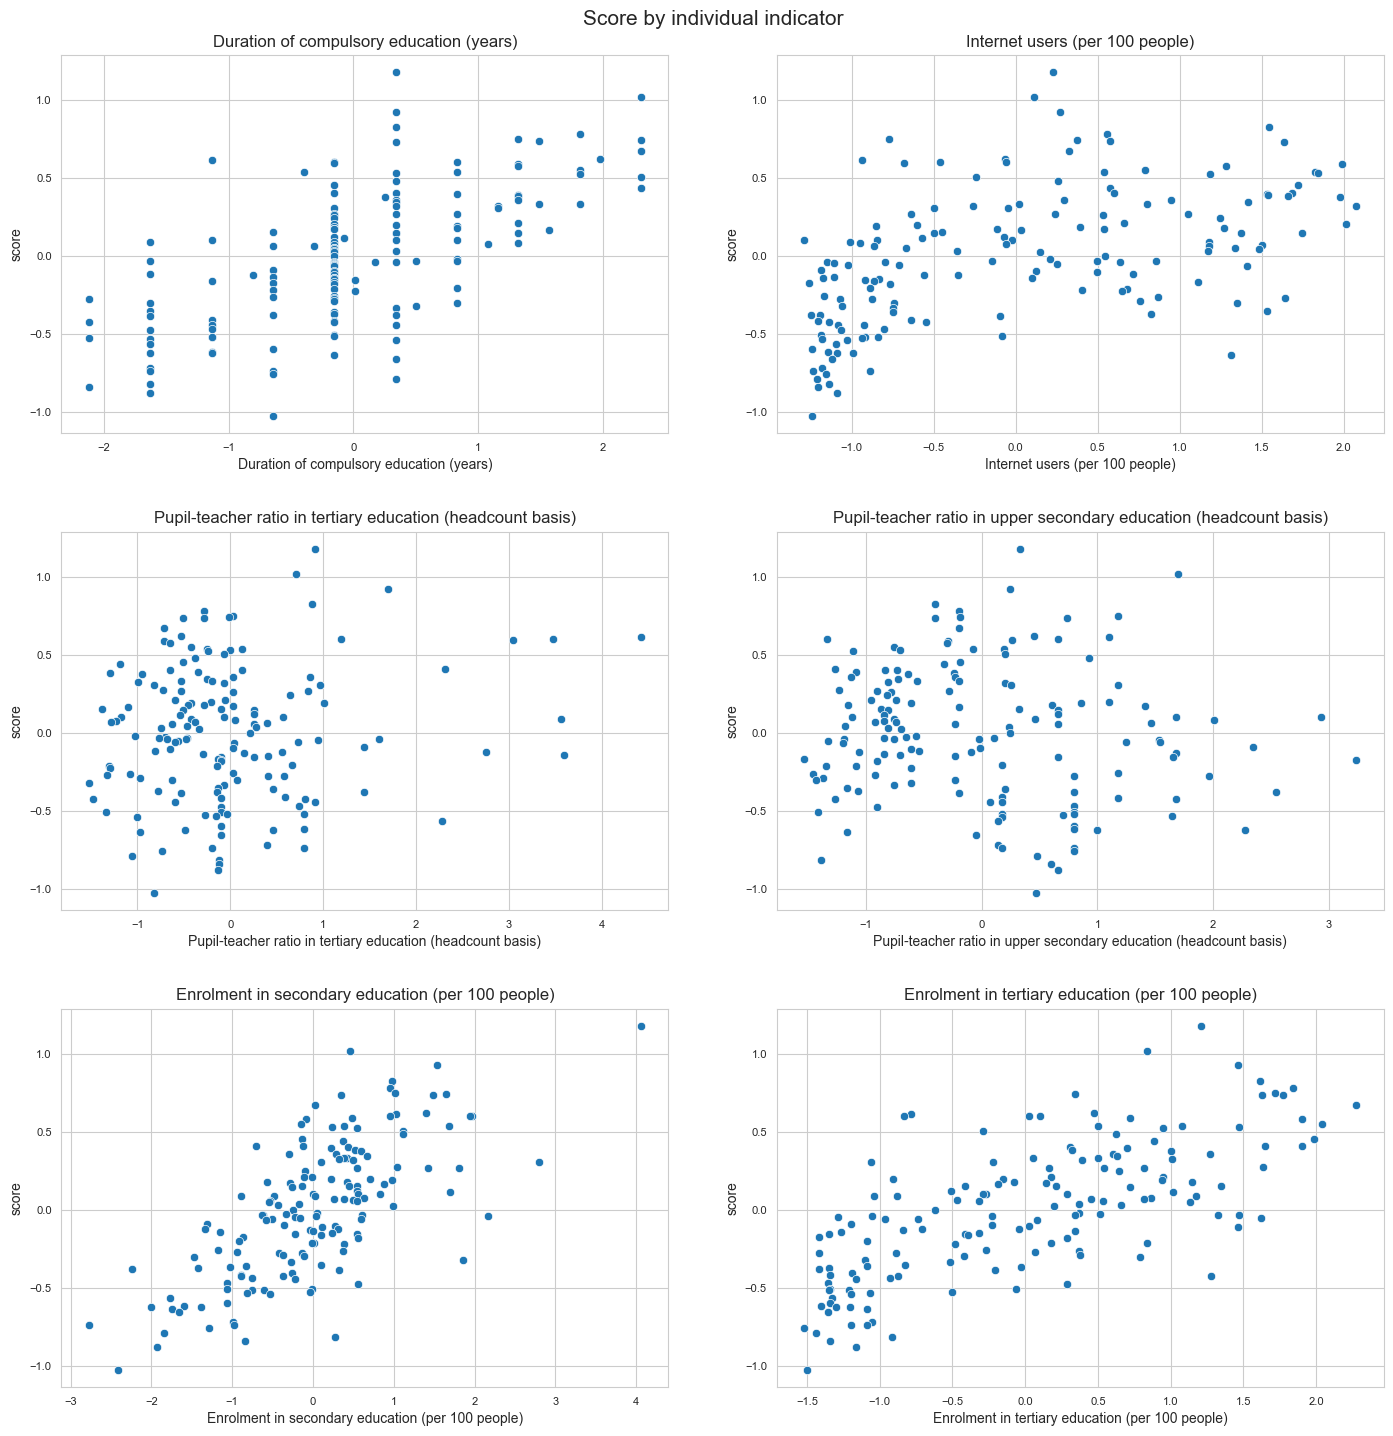

In [100]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(15, 15),sharex=False)
fig.tight_layout(pad=5.0)
for ax, col in zip(axs.ravel(),scores.columns[:-1]):
    sns.scatterplot(data=scores,x=col,y='score',ax=ax)
    ax.set_title(col,size=12)
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.tick_params(labelsize=8)
plt.suptitle('Score by individual indicator',size=15)
plt.show()  
